# Read training and testing data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, average_precision_score, roc_auc_score, \
roc_curve, precision_recall_curve

In [4]:
df_9 = pd.read_csv("/Users/suruisun/Downloads/2017_fall/df_9_20171005.csv")
df_10 = pd.read_csv("/Users/suruisun/Downloads/2017_fall/df_10_20171005.csv")
## df_10_20171005.csv is training_data.csv, df_9_20171005.csv is testing_data.csv

In [5]:
print df_9.shape, df_10.shape

(28176, 62) (27025, 62)


In [6]:
df_9.head(2)

,svm_score,PWM_score,Dnase.max,Dnase.mean,Dnase1,Dnase2,Dnase3,Dnase4,Dnase5,Dnase6,...,Dnase49,Dnase50,TSS,abs.TSS,GC_value,MGW,Roll,ProT,HelT,cell_type_num
0,-0.078416,0.863181,0.027262,0.044530,-0.058439,-0.058423,-0.192298,0.343237,0.075471,-0.192287,...,-0.336949,0.078520,0.001753,-0.344953,0.435948,-0.604466,-0.786299,0.417605,-0.594589,0.0
1,-0.646077,0.409715,0.855175,0.676114,-0.192310,-0.058423,0.075466,0.075471,-0.192290,0.209351,...,-0.059947,-0.336934,0.076405,-0.265940,0.572763,-0.472811,-0.835025,0.871371,-0.682752,0.0


cell_type_num is the binary variable, where 0.0 represents "U" (unbind) and 1.0 represents "B" (bind and ambiguous)

In [7]:
df_9.cell_type_num.value_counts()

0.0    27956
1.0      220
Name: cell_type_num, dtype: int64

In [8]:
df_10 = np.array(df_10)
Y = df_10[:,61]
X = df_10[:,:61]

df_9 = np.array(df_9)
X_val_9 = df_9[:,:61]
Y_val_9 = df_9[:,61]

print X.shape, Y.shape, X_val_9.shape, Y_val_9.shape

(27025, 61) (27025,) (28176, 61) (28176,)


In [9]:
def gmean(cf):
    try:
        tpr = float(cf[1][1])/(cf[1][1] + cf[1][0])
        tnr = float(cf[0][0])/(cf[0][0] + cf[0][1])
        return np.sqrt(tpr * tnr)
    except:
        return "DivisionByZero"


# Tuning for Logistic Regression 

In [10]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
seed = 7
### scaled data: Logistic Regression
clf = GridSearchCV(LogisticRegression(penalty='l2',random_state=seed), param_grid,cv=3) # scoring='accuracy'
clf.fit(X,Y)
print clf.best_params_

{'C': 0.01}


Best C obtained by cross validation is C = 0.01

In [11]:
## SMOTE tuning
## smote X and Y 
kind_list = ['regular','borderline1','borderline2','svm']
k_neighbors_list = [3,5,9]

In [12]:
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn import pipeline as pl
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split

from imblearn import over_sampling as os
from imblearn import pipeline as pl
from imblearn.metrics import (geometric_mean_score,
                              make_index_balanced_accuracy)

from imblearn.metrics import classification_report_imbalanced
RANDOM_STATE = 7

In [13]:
import time
import datetime

In [21]:
## smote & logistic regression FOR X_val_9
aucpr_re = []

for kd in kind_list:
    for k in k_neighbors_list:
        print "=========="
        print kd
        print k
        pipe = os.SMOTE(kind=kd,random_state=seed,k_neighbors=k)
        # pipeline = pl.make_pipeline(pipe, AdaBoostClassifier(n_estimators=50))
        pipeline = pl.make_pipeline(pipe, LogisticRegression(C=0.01,random_state=seed)) # C=0.01 is the best parameter just obtained
        
        start = time.time()
        
        pipeline.fit(X,Y)
        print "Elpased time: %s" %(time.time() - start)

        pred_9 = pipeline.predict(X_val_9)
        y_score_9 = pipeline.predict_proba(X_val_9)[:,1]
        result_f1_9 = f1_score(Y_val_9, pred_9)
        result_acc_9 = accuracy_score(Y_val_9, pred_9)
        result_conf_9 = confusion_matrix(Y_val_9, pred_9)
        result_prec_9 = precision_score(Y_val_9,pred_9)
        result_recall_9 = recall_score(Y_val_9,pred_9)
        result_gmean_9 = gmean(result_conf_9)
        result_prauc_9 = average_precision_score(Y_val_9, y_score_9)
        result_rocauc_9 = roc_auc_score(Y_val_9,y_score_9)
        #result_aucpr = average_precision_score(Y_val_unscaled, y_score)

        print "f1: %s" %(result_f1_9)
        print "acc: %s" %(result_acc_9)
        print "conf: %s" %(result_conf_9)
        print "precision: %s" %(result_prec_9)
        print "recall: %s" %(result_recall_9)
        print "gmean: %s" %(result_gmean_9)
        print "average precision: %s" %(result_prauc_9)
        print "AUC ROC: %s" %(result_rocauc_9)
        aucpr_re.append(result_prauc_9)

regular
3
Elpased time: 1.52973389626
f1: 0.122634898388
acc: 0.91113003975
conf: [[25497  2459]
 [   45   175]]
precision: 0.0664388762339
recall: 0.795454545455
gmean: 0.851755035997
average precision: 0.259556799609
AUC ROC: 0.93430171113
regular
5
Elpased time: 1.64639782906
f1: 0.121866295265
acc: 0.910491198183
conf: [[25479  2477]
 [   45   175]]
precision: 0.065987933635
recall: 0.795454545455
gmean: 0.851454328119
average precision: 0.261499300726
AUC ROC: 0.932430914164
regular
9
Elpased time: 1.00689792633
f1: 0.124823695346
acc: 0.91191084611
conf: [[25517  2439]
 [   43   177]]
precision: 0.0676605504587
recall: 0.804545454545
gmean: 0.85694427885
average precision: 0.262257603881
AUC ROC: 0.935982274093
borderline1
3
Elpased time: 2.23493719101
f1: 0.269129287599
acc: 0.97050681431
conf: [[27192   764]
 [   67   153]]
precision: 0.166848418757
recall: 0.695454545455
gmean: 0.822465017559
average precision: 0.278485737746
AUC ROC: 0.938486046255
borderline1
5
Elpased time:

In [30]:
# find the position of the maximum, index starts from 0
np.where(aucpr_re == max(aucpr_re))[0][0]

6

The best SMOTE method for AUCPR has the parameters kind = "borderline2" and k_neighbors = 3 (index 6)

In [31]:
## ADASYN
aucpr_re = []
for k in k_neighbors_list:
    pipe = ADASYN(n_neighbors=k,random_state=seed)
    pipeline = pl.make_pipeline(pipe,LogisticRegression(C=0.01,random_state=seed)) # C = 0.01 is the best parameter in original method

    start = time.time()

    print "======="
    print "k=%s" %(k)
    pipeline.fit(X,Y)
    print "Elpased time: %s" %(time.time() - start)
    
    pred_9 = pipeline.predict(X_val_9)
    y_score_9 = pipeline.predict_proba(X_val_9)[:,1]
    result_f1_9 = f1_score(Y_val_9, pred_9)
    result_acc_9 = accuracy_score(Y_val_9, pred_9)
    result_conf_9 = confusion_matrix(Y_val_9, pred_9)
    result_prec_9 = precision_score(Y_val_9,pred_9)
    result_recall_9 = recall_score(Y_val_9,pred_9)
    result_gmean_9 = gmean(result_conf_9)
    result_prauc_9 = average_precision_score(Y_val_9, y_score_9)
    result_rocauc_9 = roc_auc_score(Y_val_9,y_score_9)
    #result_aucpr = average_precision_score(Y_val_unscaled, y_score)

    print "f1: %s" %(result_f1_9)
    print "acc: %s" %(result_acc_9)
    print "conf: %s" %(result_conf_9)
    print "precision: %s" %(result_prec_9)
    print "recall: %s" %(result_recall_9)
    print "gmean: %s" %(result_gmean_9)
    print "average precision: %s" %(result_prauc_9)
    print "AUC ROC: %s" %(result_rocauc_9)
    aucpr_re.append(result_prauc_9)

k=3
Elpased time: 233.304751158
f1: 0.138888888889
acc: 0.922984099943
conf: [[25831  2125]
 [   45   175]]
precision: 0.0760869565217
recall: 0.795454545455
gmean: 0.857315701414
average precision: 0.260829985222
AUC ROC: 0.941820425604
k=5
Elpased time: 240.10616684
f1: 0.140127388535
acc: 0.923339011925
conf: [[25840  2116]
 [   44   176]]
precision: 0.0767888307155
recall: 0.8
gmean: 0.859911450984
average precision: 0.26096861139
AUC ROC: 0.941582064023
k=9
Elpased time: 265.440629005
f1: 0.140239043825
acc: 0.923409994321
conf: [[25842  2114]
 [   44   176]]
precision: 0.0768558951965
recall: 0.8
gmean: 0.859944728647
average precision: 0.260987036926
AUC ROC: 0.943130113555


In [35]:
# find the position of the maximum, index starts from 0
np.where(aucpr_re == max(aucpr_re))[0][0]

2

The best ADASYN method for AUCPR has the parameters k_neighbors = 9 (index 2)

# Summary for Logistic Regression 3 best methods

In [14]:
f1_temp9 = []
acc_temp9 = []
prec_temp9 = []
rec_temp9 = []
rocauc_temp9 = []
prauc_temp9 = []
gmean_temp9 = []
method_temp9 = []

In [39]:
## original method : 
model = LogisticRegression(C=0.01,random_state=seed) # C=0.01
model.fit(X,Y)
pred_9 = model.predict(X_val_9)
# y_score_9 = best_clf.decision_function(X_val_9)
y_score_9 = model.predict_proba(X_val_9)[:,1]
result_f1_9 = f1_score(Y_val_9, pred_9)
result_acc_9 = accuracy_score(Y_val_9, pred_9)
result_conf_9 = confusion_matrix(Y_val_9, pred_9)
result_prec_9 = precision_score(Y_val_9,pred_9)
result_recall_9 = recall_score(Y_val_9,pred_9)
result_gmean_9 = gmean(result_conf_9)
result_prauc_9 = average_precision_score(Y_val_9, y_score_9)
result_rocauc_9 = roc_auc_score(Y_val_9,y_score_9)
fpr_91, tpr_91, thresholds_91 = roc_curve(Y_val_9, y_score_9)
precision_91, recall_91, thresholds_91 = precision_recall_curve(Y_val_9,y_score_9)


print "Confusion Matrix: %s" %(result_conf_9)
f1_temp9.append(result_f1_9)
acc_temp9.append(result_acc_9)
prec_temp9.append(result_prec_9)
rec_temp9.append(result_recall_9)
gmean_temp9.append(result_gmean_9)
rocauc_temp9.append(result_rocauc_9)
prauc_temp9.append(result_prauc_9)
method_temp9.append("LR C=0.01") # LR C=0.01

Confusion Matrix: [[27910    46]
 [  187    33]]


In [40]:
## best smote method:
pipe = os.SMOTE(kind="borderline2",random_state=seed,k_neighbors=3)
pipeline = pl.make_pipeline(pipe, LogisticRegression(C=0.01,random_state=seed))

start = time.time()

pipeline.fit(X,Y)
print "Elpased time: %s" %(time.time() - start)

pred_9 = pipeline.predict(X_val_9)
y_score_9 = pipeline.predict_proba(X_val_9)[:,1]
result_f1_9 = f1_score(Y_val_9, pred_9)
result_acc_9 = accuracy_score(Y_val_9, pred_9)
result_conf_9 = confusion_matrix(Y_val_9, pred_9)
result_prec_9 = precision_score(Y_val_9,pred_9)
result_recall_9 = recall_score(Y_val_9,pred_9)
result_gmean_9 = gmean(result_conf_9)
result_prauc_9 = average_precision_score(Y_val_9, y_score_9)
result_rocauc_9 = roc_auc_score(Y_val_9,y_score_9)
#result_aucpr = average_precision_score(Y_val_unscaled, y_score)
fpr_92, tpr_92, thresholds_92 = roc_curve(Y_val_9, y_score_9)
precision_92, recall_92, thresholds_92 = precision_recall_curve(Y_val_9,y_score_9)
print "conf: %s" %(result_conf_9)

f1_temp9.append(result_f1_9)
acc_temp9.append(result_acc_9)
prec_temp9.append(result_prec_9)
rec_temp9.append(result_recall_9)
gmean_temp9.append(result_gmean_9)
rocauc_temp9.append(result_rocauc_9)
prauc_temp9.append(result_prauc_9)
method_temp9.append("LR C=0.01 SMOTE kind=borderline2 k=3")

Elpased time: 2.08500790596
conf: [[27173   783]
 [   64   156]]


In [41]:
## adasyn method:
pipe = ADASYN(n_neighbors=9,random_state=seed)
pipeline = pl.make_pipeline(pipe,LogisticRegression(C=0.01,random_state=seed))
start = time.time()
pipeline.fit(X,Y)
print "Elpased time: %s" %(time.time() - start)

pred_9 = pipeline.predict(X_val_9)
y_score_9 = pipeline.predict_proba(X_val_9)[:,1]
result_f1_9 = f1_score(Y_val_9, pred_9)
result_acc_9 = accuracy_score(Y_val_9, pred_9)
result_conf_9 = confusion_matrix(Y_val_9, pred_9)
result_prec_9 = precision_score(Y_val_9,pred_9)
result_recall_9 = recall_score(Y_val_9,pred_9)
result_gmean_9 = gmean(result_conf_9)
result_prauc_9 = average_precision_score(Y_val_9, y_score_9)
result_rocauc_9 = roc_auc_score(Y_val_9,y_score_9)
print "conf: %s" %(result_conf_9)
fpr_93, tpr_93, thresholds_93 = roc_curve(Y_val_9, y_score_9)
precision_93, recall_93, thresholds_93 = precision_recall_curve(Y_val_9,y_score_9)

f1_temp9.append(result_f1_9)
acc_temp9.append(result_acc_9)
prec_temp9.append(result_prec_9)
rec_temp9.append(result_recall_9)
gmean_temp9.append(result_gmean_9)
rocauc_temp9.append(result_rocauc_9)
prauc_temp9.append(result_prauc_9)
method_temp9.append("LR C=0.01 ADASYN k=9")

Elpased time: 277.274902821
conf: [[25842  2114]
 [   44   176]]


In [42]:
print len(f1_temp9), len(acc_temp9), len(prec_temp9), len(rec_temp9), len(rocauc_temp9), len(prauc_temp9), len(gmean_temp9), len(method_temp9)

3 3 3 3 3 3 3 3


In [43]:
total_list = zip(method_temp9,rocauc_temp9, prauc_temp9, f1_temp9, acc_temp9, gmean_temp9, prec_temp9, rec_temp9)
df_res = pd.DataFrame(total_list,columns=['Method','ROCAUC','PRAUC','F1_Score','Accuracy','Gmean','Precision','Recall'])
df_res.index = df_res.Method.values
df_res.drop('Method',axis=1,inplace=True)
df_res_lr = df_res
print df_res_lr.shape

(3, 7)


In [44]:
df_res_lr

,ROCAUC,PRAUC,F1_Score,Accuracy,Gmean,Precision,Recall
LR C=0.01,0.944355,0.275945,0.220736,0.991731,0.386980,0.417722,0.150000
LR C=0.01 SMOTE kind=borderline2 k=3,0.940262,0.288203,0.269198,0.969939,0.830199,0.166134,0.709091
LR C=0.01 ADASYN k=9,0.943130,0.260987,0.140239,0.923410,0.859945,0.076856,0.800000


# Draw ROC curve and PR curve and other plots

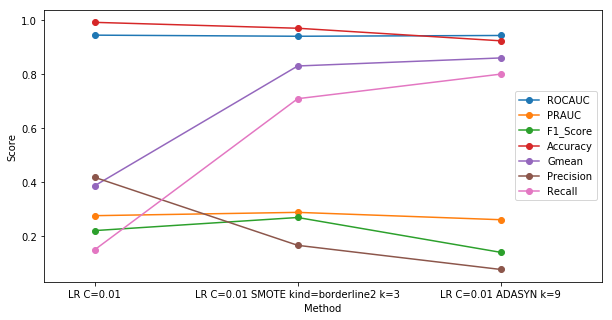

In [46]:
# Plot the results
%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt

figsize(10, 5)
ax = plt.subplot(111)

ind = np.arange(df_res.shape[0])
width = 0.2
l = ax.plot(ind, df_res, "-o")
#plt.legend(iter(l), df_res.columns.tolist(), loc='center left', bbox_to_anchor=(1, 0.5))
plt.legend(iter(l), df_res.columns.tolist(), loc='center right')
plt.ylabel('Score')
plt.xlabel('Method')
ax.set_xlim([-0.25, ind[-1]+.5])
ax.set_xticks(ind)
ax.set_xticklabels(df_res.index)
plt.show()
#plt.savefig("/Users/suruisun/Downloads/2017_fall/template-2/lr_metrics1.pdf",bbox_inches='tight')

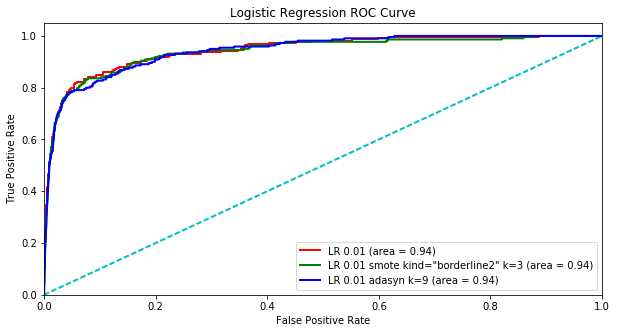

In [47]:
plt.figure(figsize=(10,5))
lw = 2
plt.plot(fpr_91, tpr_91, color='r', # #FD5C64
         lw=lw, label='LR 0.01 (area = %0.2f)' % rocauc_temp9[0])
plt.plot([0, 1], [0, 1], color='c', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')

plt.plot(fpr_92, tpr_92, color='g', # #4DD3C9
         lw=lw, label='LR 0.01 smote kind="borderline2" k=3 (area = %0.2f)' % rocauc_temp9[1])

plt.plot(fpr_93, tpr_93, color='b', # #FFA35D
         lw=lw, label='LR 0.01 adasyn k=9 (area = %0.2f)' % rocauc_temp9[2])
plt.legend(loc="lower right")

plt.show()
#plt.savefig("/Users/suruisun/Downloads/2017_fall/template-2/lr_roc_curve1.pdf",bbox_inches='tight')

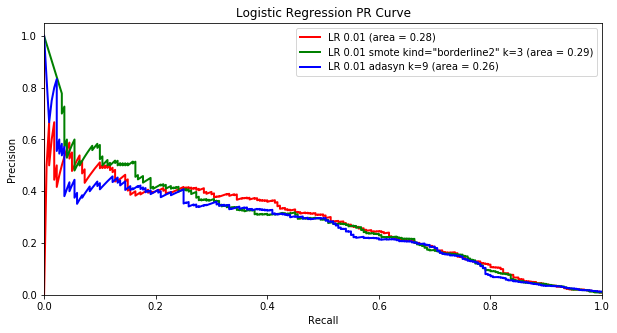

In [48]:
## draw the pr curve
plt.figure(figsize=(10,5))
lw = 2
plt.plot(recall_91, precision_91, color='r', # #FD5C64
         lw=lw, label='LR 0.01 (area = %0.2f)' % prauc_temp9[0])
#plt.plot([0, 1], [0, 1], color='c', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall') # fontsize=15
plt.ylabel('Precision')# ,fontsize=15
plt.title('Logistic Regression PR Curve') # ,fontsize=20

plt.plot(recall_92, precision_92, color='g', # #4DD3C9
         lw=lw, label='LR 0.01 smote kind="borderline2" k=3 (area = %0.2f)' % prauc_temp9[1])

plt.plot(recall_93, precision_93, color='b', # #FFA35D
         lw=lw, label='LR 0.01 adasyn k=9 (area = %0.2f)' % prauc_temp9[2])
plt.legend(loc="upper right") # ,prop={'size': 15}

plt.show()
#plt.savefig("/Users/suruisun/Downloads/2017_fall/template-2/lr_pr_curve1.pdf",bbox_inches='tight')

# Repeat the same process for KNN (K Nearest Neighbors)

In [49]:
from sklearn.neighbors import KNeighborsClassifier

In [50]:
start = time.time()
param_grid = {'n_neighbors':[3,5,7]}
clf = GridSearchCV(KNeighborsClassifier(), param_grid,cv=3,scoring='accuracy')
clf.fit(X,Y)
print clf.best_params_
print time.time() - start

{'n_neighbors': 5}
787.837558985


Best parameter n_neighbors = 5

In [51]:
aucpr_re = []
for kd in kind_list:
    for k in k_neighbors_list:
        print "=========="
        print kd
        print k
        pipe = os.SMOTE(kind=kd,random_state=seed,k_neighbors=seed)
        pipeline = pl.make_pipeline(pipe, KNeighborsClassifier(n_neighbors=5)) # 7
        
        start = time.time()
        
        pipeline.fit(X,Y)
        print "Elpased time: %s" %(time.time() - start)

        pred_9 = pipeline.predict(X_val_9)
        y_score_9 = pipeline.predict_proba(X_val_9)[:,1]
        result_f1_9 = f1_score(Y_val_9, pred_9)
        result_acc_9 = accuracy_score(Y_val_9, pred_9)
        result_conf_9 = confusion_matrix(Y_val_9, pred_9)
        result_prec_9 = precision_score(Y_val_9,pred_9)
        result_recall_9 = recall_score(Y_val_9,pred_9)
        result_gmean_9 = gmean(result_conf_9)
        result_prauc_9 = average_precision_score(Y_val_9, y_score_9)
        result_rocauc_9 = roc_auc_score(Y_val_9,y_score_9)
        #result_aucpr = average_precision_score(Y_val_unscaled, y_score)

        #print "f1: %s" %(result_f1_9)
        #print "acc: %s" %(result_acc_9)
        #print "conf: %s" %(result_conf_9)
        #print "precision: %s" %(result_prec_9)
        #print "recall: %s" %(result_recall_9)
        #print "gmean: %s" %(result_gmean_9)
        print "average precision: %s" %(result_prauc_9)
        #print "AUC ROC: %s" %(result_rocauc_9)
        
        aucpr_re.append(result_prauc_9)

regular
3
Elpased time: 0.438766002655
average precision: 0.295000775256
regular
5
Elpased time: 0.67481303215
average precision: 0.295000775256
regular
9
Elpased time: 0.437045812607
average precision: 0.295000775256
borderline1
3
Elpased time: 1.18182182312
average precision: 0.321641766925
borderline1
5
Elpased time: 1.13112020493
average precision: 0.321641766925
borderline1
9
Elpased time: 1.27939915657
average precision: 0.321641766925
borderline2
3
Elpased time: 1.45940089226
average precision: 0.281318797164
borderline2
5
Elpased time: 1.1858689785
average precision: 0.281318797164
borderline2
9
Elpased time: 1.57119607925
average precision: 0.281318797164
svm
3
Elpased time: 10.0101840496
average precision: 0.317093571888
svm
5
Elpased time: 9.89447593689
average precision: 0.317093571888
svm
9
Elpased time: 10.0970740318
average precision: 0.317093571888


In [54]:
# find the position of the maximum, index starts from 0
np.where(aucpr_re == max(aucpr_re))[0][0]

3

SMOTE kind = "borderline1" k = 5 for K Nearest Neighbors is used.

In [55]:
### Adasyn
aucpr_re = []
for k in k_neighbors_list:
    pipe = ADASYN(n_neighbors=k,random_state=seed)
    pipeline = pl.make_pipeline(pipe,KNeighborsClassifier(n_neighbors=5))

    start = time.time()

    print "======="
    print "k=%s" %(k)
    pipeline.fit(X,Y)
    print "Elpased time: %s" %(time.time() - start)
    
    pred_9 = pipeline.predict(X_val_9)
    y_score_9 = pipeline.predict_proba(X_val_9)[:,1]
    result_f1_9 = f1_score(Y_val_9, pred_9)
    result_acc_9 = accuracy_score(Y_val_9, pred_9)
    result_conf_9 = confusion_matrix(Y_val_9, pred_9)
    result_prec_9 = precision_score(Y_val_9,pred_9)
    result_recall_9 = recall_score(Y_val_9,pred_9)
    result_gmean_9 = gmean(result_conf_9)
    result_prauc_9 = average_precision_score(Y_val_9, y_score_9)
    result_rocauc_9 = roc_auc_score(Y_val_9,y_score_9)
    #result_aucpr = average_precision_score(Y_val_unscaled, y_score)

#     print "f1: %s" %(result_f1_9)
#     print "acc: %s" %(result_acc_9)
#     print "conf: %s" %(result_conf_9)
#     print "precision: %s" %(result_prec_9)
#     print "recall: %s" %(result_recall_9)
#     print "gmean: %s" %(result_gmean_9)
    print "average precision: %s" %(result_prauc_9)
#     print "AUC ROC: %s" %(result_rocauc_9)
    aucpr_re.append(result_prauc_9)

k=3
Elpased time: 309.373752117
average precision: 0.24755969437
k=5
Elpased time: 256.574120045
average precision: 0.256621393233
k=9
Elpased time: 259.967797995
average precision: 0.249598697282


In [56]:
# find the position of the maximum, index starts from 0
np.where(aucpr_re == max(aucpr_re))[0][0]

1

ADASYN k = 5 for K Nearest Neighbors is used.

# Summary of 3 methods for K Nearest Neighbors

In [57]:
f1_temp9 = []
acc_temp9 = []
prec_temp9 = []
rec_temp9 = []
rocauc_temp9 = []
prauc_temp9 = []
gmean_temp9 = []
method_temp9 = []

In [58]:
## original method : 
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X,Y)
pred_9 = model.predict(X_val_9)
# y_score_9 = best_clf.decision_function(X_val_9)
y_score_9 = model.predict_proba(X_val_9)[:,1]
result_f1_9 = f1_score(Y_val_9, pred_9)
result_acc_9 = accuracy_score(Y_val_9, pred_9)
result_conf_9 = confusion_matrix(Y_val_9, pred_9)
result_prec_9 = precision_score(Y_val_9,pred_9)
result_recall_9 = recall_score(Y_val_9,pred_9)
result_gmean_9 = gmean(result_conf_9)
result_prauc_9 = average_precision_score(Y_val_9, y_score_9)
result_rocauc_9 = roc_auc_score(Y_val_9,y_score_9)
fpr_91, tpr_91, thresholds_91 = roc_curve(Y_val_9, y_score_9)
precision_91, recall_91, thresholds_91 = precision_recall_curve(Y_val_9,y_score_9)


print "Confusion Matrix: %s" %(result_conf_9)
f1_temp9.append(result_f1_9)
acc_temp9.append(result_acc_9)
prec_temp9.append(result_prec_9)
rec_temp9.append(result_recall_9)
gmean_temp9.append(result_gmean_9)
rocauc_temp9.append(result_rocauc_9)
prauc_temp9.append(result_prauc_9)
method_temp9.append("KNN k=5")

Confusion Matrix: [[27916    40]
 [  199    21]]


In [59]:
## best smote method:
pipe = os.SMOTE(kind="borderline1",random_state=seed,k_neighbors=5)
pipeline = pl.make_pipeline(pipe, KNeighborsClassifier(n_neighbors=5))

start = time.time()

pipeline.fit(X,Y)
print "Elpased time: %s" %(time.time() - start)

pred_9 = pipeline.predict(X_val_9)
y_score_9 = pipeline.predict_proba(X_val_9)[:,1]
result_f1_9 = f1_score(Y_val_9, pred_9)
result_acc_9 = accuracy_score(Y_val_9, pred_9)
result_conf_9 = confusion_matrix(Y_val_9, pred_9)
result_prec_9 = precision_score(Y_val_9,pred_9)
result_recall_9 = recall_score(Y_val_9,pred_9)
result_gmean_9 = gmean(result_conf_9)
result_prauc_9 = average_precision_score(Y_val_9, y_score_9)
result_rocauc_9 = roc_auc_score(Y_val_9,y_score_9)
#result_aucpr = average_precision_score(Y_val_unscaled, y_score)
fpr_92, tpr_92, thresholds_92 = roc_curve(Y_val_9, y_score_9)
precision_92, recall_92, thresholds_92 = precision_recall_curve(Y_val_9,y_score_9)
print "conf: %s" %(result_conf_9)

f1_temp9.append(result_f1_9)
acc_temp9.append(result_acc_9)
prec_temp9.append(result_prec_9)
rec_temp9.append(result_recall_9)
gmean_temp9.append(result_gmean_9)
rocauc_temp9.append(result_rocauc_9)
prauc_temp9.append(result_prauc_9)
method_temp9.append("KNN k=5 SMOTE kind=borderline1 k=5")

Elpased time: 1.41289401054
conf: [[27079   877]
 [   88   132]]


In [60]:
## adasyn method:
pipe = ADASYN(n_neighbors=5,random_state=seed)
pipeline = pl.make_pipeline(pipe,KNeighborsClassifier(n_neighbors=5))
start = time.time()
pipeline.fit(X,Y)
print "Elpased time: %s" %(time.time() - start)

pred_9 = pipeline.predict(X_val_9)
y_score_9 = pipeline.predict_proba(X_val_9)[:,1]
result_f1_9 = f1_score(Y_val_9, pred_9)
result_acc_9 = accuracy_score(Y_val_9, pred_9)
result_conf_9 = confusion_matrix(Y_val_9, pred_9)
result_prec_9 = precision_score(Y_val_9,pred_9)
result_recall_9 = recall_score(Y_val_9,pred_9)
result_gmean_9 = gmean(result_conf_9)
result_prauc_9 = average_precision_score(Y_val_9, y_score_9)
result_rocauc_9 = roc_auc_score(Y_val_9,y_score_9)
print "conf: %s" %(result_conf_9)
fpr_93, tpr_93, thresholds_93 = roc_curve(Y_val_9, y_score_9)
precision_93, recall_93, thresholds_93 = precision_recall_curve(Y_val_9,y_score_9)

f1_temp9.append(result_f1_9)
acc_temp9.append(result_acc_9)
prec_temp9.append(result_prec_9)
rec_temp9.append(result_recall_9)
gmean_temp9.append(result_gmean_9)
rocauc_temp9.append(result_rocauc_9)
prauc_temp9.append(result_prauc_9)
method_temp9.append("KNN k=5 ADASYN k=5")

Elpased time: 262.482800007
conf: [[27599   357]
 [  126    94]]


In [61]:
print len(f1_temp9), len(acc_temp9), len(prec_temp9), len(rec_temp9), len(rocauc_temp9), len(prauc_temp9), len(gmean_temp9), len(method_temp9)
total_list = zip(method_temp9,rocauc_temp9, prauc_temp9, f1_temp9, acc_temp9, gmean_temp9, prec_temp9, rec_temp9)
df_res = pd.DataFrame(total_list,columns=['Method','ROCAUC','PRAUC','F1_Score','Accuracy','Gmean','Precision','Recall'])
df_res.index = df_res.Method.values
df_res.drop('Method',axis=1,inplace=True)
df_res

3 3 3 3 3 3 3 3


,ROCAUC,PRAUC,F1_Score,Accuracy,Gmean,Precision,Recall
KNN k=5,0.719370,0.191784,0.149466,0.991518,0.308736,0.344262,0.095455
KNN k=5 SMOTE kind=borderline1 k=5,0.816600,0.310104,0.214809,0.965751,0.762350,0.130823,0.600000
KNN k=5 ADASYN k=5,0.737095,0.256621,0.280179,0.982858,0.649474,0.208426,0.427273


In [62]:
df_res_knn = df_res

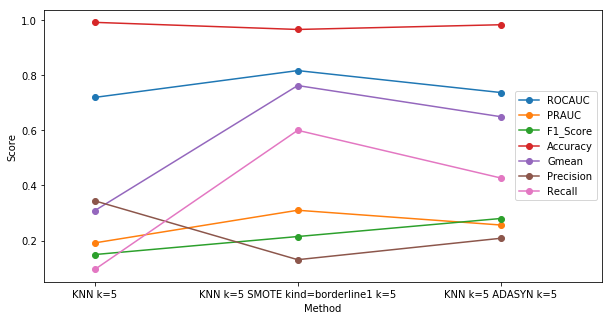

In [63]:
# Plot the results
%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt

figsize(10, 5)
ax = plt.subplot(111)

ind = np.arange(df_res.shape[0])
width = 0.2
l = ax.plot(ind, df_res, "-o")
#plt.legend(iter(l), df_res.columns.tolist(), loc='upper left', bbox_to_anchor=(1, 0.5)) # center left
leg = plt.legend(iter(l), df_res.columns.tolist(), loc='center right',fancybox=True)
#leg.get_frame().set_alpha(0.05)
plt.ylabel('Score')
plt.xlabel('Method')
ax.set_xlim([-0.25, ind[-1]+0.5])
ax.set_xticks(ind)
ax.set_xticklabels(df_res.index)
#plt.savefig("/Users/suruisun/Downloads/2017_fall/template-2/knn_metrics1.pdf",bbox_inches='tight')
#bbox_extra_artists=(lgd,), 
plt.show()

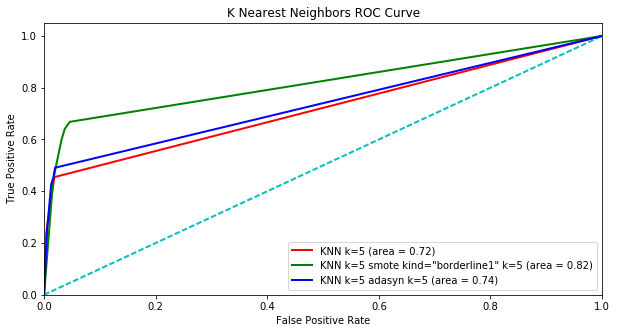

In [64]:
plt.figure(figsize=(10,5))
lw = 2
plt.plot(fpr_91, tpr_91, color='r', # #FD5C64
         lw=lw, label='KNN k=5 (area = %0.2f)' % rocauc_temp9[0])
plt.plot([0, 1], [0, 1], color='c', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('K Nearest Neighbors ROC Curve')

plt.plot(fpr_92, tpr_92, color='g', # #4DD3C9
         lw=lw, label='KNN k=5 smote kind="borderline1" k=5 (area = %0.2f)' % rocauc_temp9[1])

plt.plot(fpr_93, tpr_93, color='b', # #FFA35D
         lw=lw, label='KNN k=5 adasyn k=5 (area = %0.2f)' % rocauc_temp9[2])
plt.legend(loc="lower right")
#plt.savefig("/Users/suruisun/Downloads/2017_fall/template-2/knn_roc_curve1.pdf",bbox_inches='tight')
plt.show()

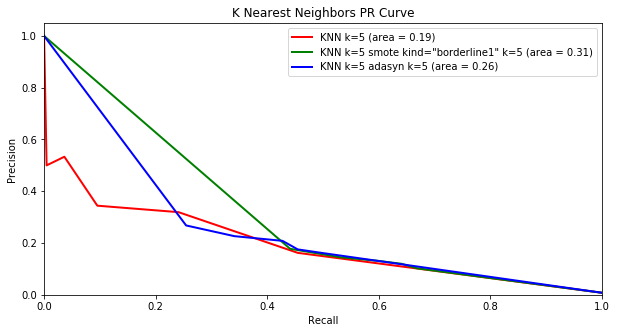

In [65]:
## draw the pr curve
plt.figure(figsize=(10,5))
lw = 2
plt.plot(recall_91, precision_91, color='r', # #FD5C64
         lw=lw, label='KNN k=5 (area = %0.2f)' % prauc_temp9[0])
#plt.plot([0, 1], [0, 1], color='c', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('K Nearest Neighbors PR Curve')

plt.plot(recall_92, precision_92, color='g', # #4DD3C9
         lw=lw, label='KNN k=5 smote kind="borderline1" k=5 (area = %0.2f)' % prauc_temp9[1])

plt.plot(recall_93, precision_93, color='b', # #FFA35D
         lw=lw, label='KNN k=5 adasyn k=5 (area = %0.2f)' % prauc_temp9[2])
plt.legend(loc="upper right")
#plt.savefig("/Users/suruisun/Downloads/2017_fall/template-2/knn_pr_curve1.pdf",bbox_inches='tight')
plt.show()

# Random Forest

In [66]:
from sklearn.ensemble import RandomForestClassifier

In [67]:
start = time.time()
param_grid = {'n_estimators' :[10,100,200], 'criterion': ['entropy','gini']} 
clf = GridSearchCV(RandomForestClassifier(random_state=seed), param_grid,cv=3,scoring='accuracy')
clf.fit(X,Y)
print clf.best_params_
print time.time() - start

{'n_estimators': 200, 'criterion': 'gini'}
101.072540045


Best parameter: n_estimators = 200 and criterion = 'gini'

In [69]:
aucpr_re = []
for kd in kind_list:
    for k in k_neighbors_list:
        print "=========="
        print kd
        print k
        pipe = os.SMOTE(kind=kd,random_state=seed,k_neighbors=k)
        pipeline = pl.make_pipeline(pipe,RandomForestClassifier(random_state=seed,n_estimators=200,criterion="gini"))
        
        start = time.time()
        
        pipeline.fit(X,Y)
        print "Elpased time: %s" %(time.time() - start)

        pred_9 = pipeline.predict(X_val_9)
        y_score_9 = pipeline.predict_proba(X_val_9)[:,1]
        result_f1_9 = f1_score(Y_val_9, pred_9)
        result_acc_9 = accuracy_score(Y_val_9, pred_9)
        result_conf_9 = confusion_matrix(Y_val_9, pred_9)
        result_prec_9 = precision_score(Y_val_9,pred_9)
        result_recall_9 = recall_score(Y_val_9,pred_9)
        result_gmean_9 = gmean(result_conf_9)
        result_prauc_9 = average_precision_score(Y_val_9, y_score_9)
        result_rocauc_9 = roc_auc_score(Y_val_9,y_score_9)
        #result_aucpr = average_precision_score(Y_val_unscaled, y_score)
        aucpr_re.append(result_prauc_9)

#         print "f1: %s" %(result_f1_9)
#         print "acc: %s" %(result_acc_9)
#         print "conf: %s" %(result_conf_9)
#         print "precision: %s" %(result_prec_9)
#         print "recall: %s" %(result_recall_9)
#         print "gmean: %s" %(result_gmean_9)
#         print "average precision: %s" %(result_prauc_9)
#         print "AUC ROC: %s" %(result_rocauc_9)

regular
3
Elpased time: 102.616171122
regular
5
Elpased time: 111.711297035
regular
9
Elpased time: 92.5353507996
borderline1
3
Elpased time: 114.273307085
borderline1
5
Elpased time: 109.299490929
borderline1
9
Elpased time: 106.044679165
borderline2
3
Elpased time: 103.791306019
borderline2
5
Elpased time: 102.531532049
borderline2
9
Elpased time: 103.716675997
svm
3
Elpased time: 86.78667593
svm
5
Elpased time: 83.3885688782
svm
9
Elpased time: 80.4142401218


In [70]:
# find the position of the maximum, index starts from 0
np.where(aucpr_re == max(aucpr_re))[0][0]

11

Best paramter for SMOTE: kind = "svm" and k_neighbors = 9

In [71]:
### Adasyn
aucpr_re = []
for k in k_neighbors_list:
    pipe = ADASYN(n_neighbors=k,random_state=seed)
    pipeline = pl.make_pipeline(pipe,RandomForestClassifier(random_state=seed,n_estimators = 200,criterion="gini"))

    start = time.time()

    print "======="
    print "k=%s" %(k)
    pipeline.fit(X,Y)
    print "Elpased time: %s" %(time.time() - start)
    
    pred_9 = pipeline.predict(X_val_9)
    y_score_9 = pipeline.predict_proba(X_val_9)[:,1]
    result_f1_9 = f1_score(Y_val_9, pred_9)
    result_acc_9 = accuracy_score(Y_val_9, pred_9)
    result_conf_9 = confusion_matrix(Y_val_9, pred_9)
    result_prec_9 = precision_score(Y_val_9,pred_9)
    result_recall_9 = recall_score(Y_val_9,pred_9)
    result_gmean_9 = gmean(result_conf_9)
    result_prauc_9 = average_precision_score(Y_val_9, y_score_9)
    result_rocauc_9 = roc_auc_score(Y_val_9,y_score_9)
    #result_aucpr = average_precision_score(Y_val_unscaled, y_score)
    aucpr_re.append(result_prauc_9)

#     print "f1: %s" %(result_f1_9)
#     print "acc: %s" %(result_acc_9)
#     print "conf: %s" %(result_conf_9)
#     print "precision: %s" %(result_prec_9)
#     print "recall: %s" %(result_recall_9)
#     print "gmean: %s" %(result_gmean_9)
#     print "average precision: %s" %(result_prauc_9)
#     print "AUC ROC: %s" %(result_rocauc_9)


k=3
Elpased time: 340.636893988
k=5
Elpased time: 316.581894159
k=9
Elpased time: 305.336384058


In [72]:
# find the position of the maximum, index starts from 0
np.where(aucpr_re == max(aucpr_re))[0][0]

2

Best parameter for ADASYN n_neighbors=9

In [73]:
f1_temp9 = []
acc_temp9 = []
prec_temp9 = []
rec_temp9 = []
rocauc_temp9 = []
prauc_temp9 = []
gmean_temp9 = []
method_temp9 = []

In [74]:
## original method : 
model = RandomForestClassifier(random_state=seed,n_estimators = 200)
model.fit(X,Y)
pred_9 = model.predict(X_val_9)
# y_score_9 = best_clf.decision_function(X_val_9)
y_score_9 = model.predict_proba(X_val_9)[:,1]
result_f1_9 = f1_score(Y_val_9, pred_9)
result_acc_9 = accuracy_score(Y_val_9, pred_9)
result_conf_9 = confusion_matrix(Y_val_9, pred_9)
result_prec_9 = precision_score(Y_val_9,pred_9)
result_recall_9 = recall_score(Y_val_9,pred_9)
result_gmean_9 = gmean(result_conf_9)
result_prauc_9 = average_precision_score(Y_val_9, y_score_9)
result_rocauc_9 = roc_auc_score(Y_val_9,y_score_9)
fpr_91, tpr_91, thresholds_91 = roc_curve(Y_val_9, y_score_9)
precision_91, recall_91, thresholds_91 = precision_recall_curve(Y_val_9,y_score_9)

print "Confusion Matrix: %s" %(result_conf_9)
f1_temp9.append(result_f1_9)
acc_temp9.append(result_acc_9)
prec_temp9.append(result_prec_9)
rec_temp9.append(result_recall_9)
gmean_temp9.append(result_gmean_9)
rocauc_temp9.append(result_rocauc_9)
prauc_temp9.append(result_prauc_9)
method_temp9.append("RF n_estimators = 200")

Confusion Matrix: [[27935    21]
 [  203    17]]


In [75]:
## best smote method:
pipe = os.SMOTE(kind="svm",random_state=seed,k_neighbors=9)
pipeline = pl.make_pipeline(pipe, RandomForestClassifier(random_state=seed,n_estimators = 200))

start = time.time()

pipeline.fit(X,Y)
print "Elpased time: %s" %(time.time() - start)

pred_9 = pipeline.predict(X_val_9)
y_score_9 = pipeline.predict_proba(X_val_9)[:,1]
result_f1_9 = f1_score(Y_val_9, pred_9)
result_acc_9 = accuracy_score(Y_val_9, pred_9)
result_conf_9 = confusion_matrix(Y_val_9, pred_9)
result_prec_9 = precision_score(Y_val_9,pred_9)
result_recall_9 = recall_score(Y_val_9,pred_9)
result_gmean_9 = gmean(result_conf_9)
result_prauc_9 = average_precision_score(Y_val_9, y_score_9)
result_rocauc_9 = roc_auc_score(Y_val_9,y_score_9)
#result_aucpr = average_precision_score(Y_val_unscaled, y_score)
fpr_92, tpr_92, thresholds_92 = roc_curve(Y_val_9, y_score_9)
precision_92, recall_92, thresholds_92 = precision_recall_curve(Y_val_9,y_score_9)
print "conf: %s" %(result_conf_9)

f1_temp9.append(result_f1_9)
acc_temp9.append(result_acc_9)
prec_temp9.append(result_prec_9)
rec_temp9.append(result_recall_9)
gmean_temp9.append(result_gmean_9)
rocauc_temp9.append(result_rocauc_9)
prauc_temp9.append(result_prauc_9)
method_temp9.append("RF n_estimators=200 SMOTE kind=svm k=9")

Elpased time: 100.588351011
conf: [[27534   422]
 [   90   130]]


In [76]:
## adasyn method:
pipe = ADASYN(n_neighbors=9,random_state=seed)
pipeline = pl.make_pipeline(pipe,RandomForestClassifier(random_state=seed,n_estimators = 200))
start = time.time()
pipeline.fit(X,Y)
print "Elpased time: %s" %(time.time() - start)

pred_9 = pipeline.predict(X_val_9)
y_score_9 = pipeline.predict_proba(X_val_9)[:,1]
result_f1_9 = f1_score(Y_val_9, pred_9)
result_acc_9 = accuracy_score(Y_val_9, pred_9)
result_conf_9 = confusion_matrix(Y_val_9, pred_9)
result_prec_9 = precision_score(Y_val_9,pred_9)
result_recall_9 = recall_score(Y_val_9,pred_9)
result_gmean_9 = gmean(result_conf_9)
result_prauc_9 = average_precision_score(Y_val_9, y_score_9)
result_rocauc_9 = roc_auc_score(Y_val_9,y_score_9)
print "conf: %s" %(result_conf_9)
fpr_93, tpr_93, thresholds_93 = roc_curve(Y_val_9, y_score_9)
precision_93, recall_93, thresholds_93 = precision_recall_curve(Y_val_9,y_score_9)

f1_temp9.append(result_f1_9)
acc_temp9.append(result_acc_9)
prec_temp9.append(result_prec_9)
rec_temp9.append(result_recall_9)
gmean_temp9.append(result_gmean_9)
rocauc_temp9.append(result_rocauc_9)
prauc_temp9.append(result_prauc_9)
method_temp9.append("RF n_estimators=200 ADASYN k=9")

Elpased time: 301.940424919
conf: [[27543   413]
 [   90   130]]


In [77]:
print len(f1_temp9), len(acc_temp9), len(prec_temp9), len(rec_temp9), len(rocauc_temp9), len(prauc_temp9), len(gmean_temp9), len(method_temp9)
total_list = zip(method_temp9,rocauc_temp9, prauc_temp9, f1_temp9, acc_temp9, gmean_temp9, prec_temp9, rec_temp9)
df_res = pd.DataFrame(total_list,columns=['Method','ROCAUC','PRAUC','F1_Score','Accuracy','Gmean','Precision','Recall'])
df_res.index = df_res.Method.values
df_res.drop('Method',axis=1,inplace=True)
df_res

3 3 3 3 3 3 3 3


,ROCAUC,PRAUC,F1_Score,Accuracy,Gmean,Precision,Recall
RF n_estimators = 200,0.918991,0.281855,0.131783,0.992050,0.277875,0.447368,0.077273
RF n_estimators=200 SMOTE kind=svm k=9,0.926716,0.253408,0.336788,0.981829,0.762882,0.235507,0.590909
RF n_estimators=200 ADASYN k=9,0.943071,0.281780,0.340760,0.982148,0.763007,0.239411,0.590909


In [78]:
df_res_rf = df_res

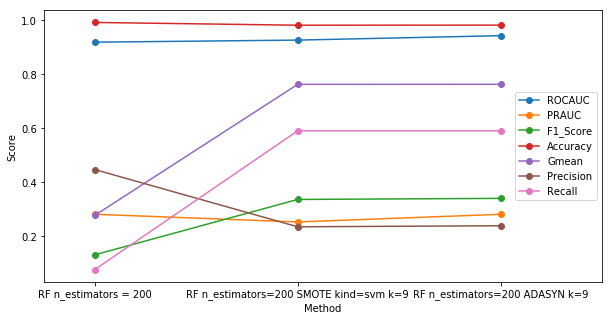

In [79]:
# Plot the results
%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt

figsize(10, 5)
ax = plt.subplot(111)

ind = np.arange(df_res.shape[0])
width = 0.2
l = ax.plot(ind, df_res, "-o")
leg = plt.legend(iter(l), df_res.columns.tolist(), loc='center right',fancybox=True)
#leg.get_frame().set_alpha(0.05)
plt.ylabel('Score')
plt.xlabel('Method')
ax.set_xlim([-0.25, ind[-1]+0.5])
ax.set_xticks(ind)
ax.set_xticklabels(df_res.index)
plt.show()
#plt.savefig("/Users/suruisun/Downloads/2017_fall/template-2/rf_metrics1.pdf",bbox_inches='tight')

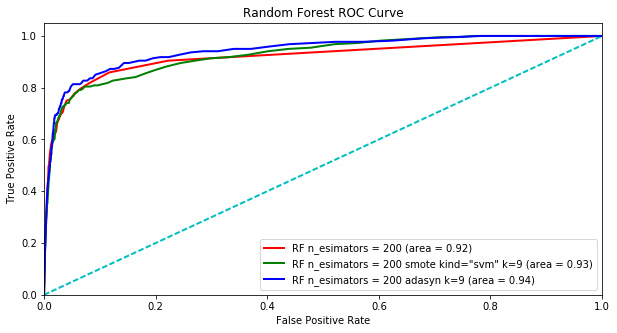

In [80]:
plt.figure(figsize=(10,5))
lw = 2
plt.plot(fpr_91, tpr_91, color='r', # #FD5C64
         lw=lw, label='RF n_esimators = 200 (area = %0.2f)' % rocauc_temp9[0])
plt.plot([0, 1], [0, 1], color='c', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve')

plt.plot(fpr_92, tpr_92, color='g', # #4DD3C9
         lw=lw, label='RF n_esimators = 200 smote kind="svm" k=9 (area = %0.2f)' % rocauc_temp9[1])

plt.plot(fpr_93, tpr_93, color='b', # #FFA35D
         lw=lw, label='RF n_esimators = 200 adasyn k=9 (area = %0.2f)' % rocauc_temp9[2])
plt.legend(loc="lower right")
#plt.savefig("/Users/suruisun/Downloads/2017_fall/template-2/rf_roc_curve1.pdf",bbox_inches='tight')
plt.show()

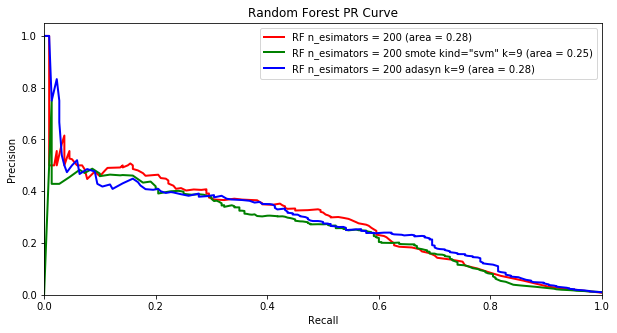

In [81]:
## draw the pr curve
plt.figure(figsize=(10,5))
lw = 2
plt.plot(recall_91, precision_91, color='r', # #FD5C64
         lw=lw, label='RF n_esimators = 200 (area = %0.2f)' % prauc_temp9[0])
#plt.plot([0, 1], [0, 1], color='c', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Random Forest PR Curve')

plt.plot(recall_92, precision_92, color='g', # #4DD3C9
         lw=lw, label='RF n_esimators = 200 smote kind="svm" k=9 (area = %0.2f)' % prauc_temp9[1])

plt.plot(recall_93, precision_93, color='b', # #FFA35D
         lw=lw, label='RF n_esimators = 200 adasyn k=9 (area = %0.2f)' % prauc_temp9[2])
plt.legend(loc="upper right")
#plt.savefig("/Users/suruisun/Downloads/2017_fall/template-2/rf_pr_curve1.pdf",bbox_inches='tight')
plt.show()

# Adaboost

In [82]:
from sklearn.ensemble import AdaBoostClassifier

In [83]:
start = time.time()
param_grid = {'n_estimators' :[50,100,500]} 
clf = GridSearchCV(AdaBoostClassifier(random_state=seed), param_grid,cv=3,scoring='accuracy')
clf.fit(X,Y)
print clf.best_params_
print time.time() - start

{'n_estimators': 50}
122.811341047


Best parameter: n_estimators = 50

In [84]:
aucpr_re = []
for kd in kind_list:
    for k in k_neighbors_list:
        print "=========="
        print kd
        print k
        pipe = os.SMOTE(kind=kd,random_state=seed,k_neighbors=k)
        pipeline = pl.make_pipeline(pipe,AdaBoostClassifier(random_state=seed,n_estimators=50))
        
        start = time.time()
        
        pipeline.fit(X,Y)
        print "Elpased time: %s" %(time.time() - start)

        pred_9 = pipeline.predict(X_val_9)
        y_score_9 = pipeline.predict_proba(X_val_9)[:,1]
        result_f1_9 = f1_score(Y_val_9, pred_9)
        result_acc_9 = accuracy_score(Y_val_9, pred_9)
        result_conf_9 = confusion_matrix(Y_val_9, pred_9)
        result_prec_9 = precision_score(Y_val_9,pred_9)
        result_recall_9 = recall_score(Y_val_9,pred_9)
        result_gmean_9 = gmean(result_conf_9)
        result_prauc_9 = average_precision_score(Y_val_9, y_score_9)
        result_rocauc_9 = roc_auc_score(Y_val_9,y_score_9)
        #result_aucpr = average_precision_score(Y_val_unscaled, y_score)

        print "average precision: %s" %(result_prauc_9)
        aucpr_re.append(result_prauc_9)

regular
3
Elpased time: 17.1881639957
average precision: 0.0639948115757
regular
5
Elpased time: 17.4294168949
average precision: 0.0455505057809
regular
9
Elpased time: 15.348815918
average precision: 0.0548827813196
borderline1
3
Elpased time: 15.2061519623
average precision: 0.160241264318
borderline1
5
Elpased time: 15.3838791847
average precision: 0.174525553617
borderline1
9
Elpased time: 15.2058467865
average precision: 0.19143739988
borderline2
3
Elpased time: 15.3806958199
average precision: 0.169678053196
borderline2
5
Elpased time: 15.3514821529
average precision: 0.172601721107
borderline2
9
Elpased time: 15.4773991108
average precision: 0.153967288875
svm
3
Elpased time: 20.6311199665
average precision: 0.201584897356
svm
5
Elpased time: 20.8373169899
average precision: 0.19385954439
svm
9
Elpased time: 20.8699219227
average precision: 0.212426330339


In [85]:
np.where(aucpr_re == max(aucpr_re))[0][0]

11

Best SMOTE kind= "svm" k_neighbors = 9

In [86]:
### Adasyn
aucpr_re = []
for k in k_neighbors_list:
    pipe = ADASYN(n_neighbors=k,random_state=seed)
    pipeline = pl.make_pipeline(pipe,AdaBoostClassifier(random_state=seed,n_estimators = 50))

    start = time.time()

    print "======="
    print "k=%s" %(k)
    pipeline.fit(X,Y)
    print "Elpased time: %s" %(time.time() - start)
    
    pred_9 = pipeline.predict(X_val_9)
    y_score_9 = pipeline.predict_proba(X_val_9)[:,1]
    result_f1_9 = f1_score(Y_val_9, pred_9)
    result_acc_9 = accuracy_score(Y_val_9, pred_9)
    result_conf_9 = confusion_matrix(Y_val_9, pred_9)
    result_prec_9 = precision_score(Y_val_9,pred_9)
    result_recall_9 = recall_score(Y_val_9,pred_9)
    result_gmean_9 = gmean(result_conf_9)
    result_prauc_9 = average_precision_score(Y_val_9, y_score_9)
    result_rocauc_9 = roc_auc_score(Y_val_9,y_score_9)
    #result_aucpr = average_precision_score(Y_val_unscaled, y_score)

    print "average precision: %s" %(result_prauc_9)
    aucpr_re.append(result_prauc_9)

k=3
Elpased time: 244.344863892
average precision: 0.149685756882
k=5
Elpased time: 237.232470036
average precision: 0.134842209596
k=9
Elpased time: 248.79596591
average precision: 0.173473570676


In [87]:
np.where(aucpr_re == max(aucpr_re))[0][0]

2

Best ADASYN n_neighbors = 9

In [88]:
f1_temp9 = []
acc_temp9 = []
prec_temp9 = []
rec_temp9 = []
rocauc_temp9 = []
prauc_temp9 = []
gmean_temp9 = []
method_temp9 = []

In [89]:
## original method : 
model = AdaBoostClassifier(random_state=seed,n_estimators=50)
model.fit(X,Y)
pred_9 = model.predict(X_val_9)
# y_score_9 = best_clf.decision_function(X_val_9)
y_score_9 = model.predict_proba(X_val_9)[:,1]
result_f1_9 = f1_score(Y_val_9, pred_9)
result_acc_9 = accuracy_score(Y_val_9, pred_9)
result_conf_9 = confusion_matrix(Y_val_9, pred_9)
result_prec_9 = precision_score(Y_val_9,pred_9)
result_recall_9 = recall_score(Y_val_9,pred_9)
result_gmean_9 = gmean(result_conf_9)
result_prauc_9 = average_precision_score(Y_val_9, y_score_9)
result_rocauc_9 = roc_auc_score(Y_val_9,y_score_9)
fpr_91, tpr_91, thresholds_91 = roc_curve(Y_val_9, y_score_9)
precision_91, recall_91, thresholds_91 = precision_recall_curve(Y_val_9,y_score_9)

print "Confusion Matrix: %s" %(result_conf_9)
f1_temp9.append(result_f1_9)
acc_temp9.append(result_acc_9)
prec_temp9.append(result_prec_9)
rec_temp9.append(result_recall_9)
gmean_temp9.append(result_gmean_9)
rocauc_temp9.append(result_rocauc_9)
prauc_temp9.append(result_prauc_9)
method_temp9.append("ADA n_estimators = 50")

Confusion Matrix: [[27857    99]
 [  168    52]]


In [90]:
## best smote method:
pipe = os.SMOTE(kind="svm",random_state=seed,k_neighbors=9)
pipeline = pl.make_pipeline(pipe, AdaBoostClassifier(random_state=seed,n_estimators=50))

start = time.time()

pipeline.fit(X,Y)
print "Elpased time: %s" %(time.time() - start)

pred_9 = pipeline.predict(X_val_9)
y_score_9 = pipeline.predict_proba(X_val_9)[:,1]
result_f1_9 = f1_score(Y_val_9, pred_9)
result_acc_9 = accuracy_score(Y_val_9, pred_9)
result_conf_9 = confusion_matrix(Y_val_9, pred_9)
result_prec_9 = precision_score(Y_val_9,pred_9)
result_recall_9 = recall_score(Y_val_9,pred_9)
result_gmean_9 = gmean(result_conf_9)
result_prauc_9 = average_precision_score(Y_val_9, y_score_9)
result_rocauc_9 = roc_auc_score(Y_val_9,y_score_9)
#result_aucpr = average_precision_score(Y_val_unscaled, y_score)
fpr_92, tpr_92, thresholds_92 = roc_curve(Y_val_9, y_score_9)
precision_92, recall_92, thresholds_92 = precision_recall_curve(Y_val_9,y_score_9)
print "conf: %s" %(result_conf_9)

f1_temp9.append(result_f1_9)
acc_temp9.append(result_acc_9)
prec_temp9.append(result_prec_9)
rec_temp9.append(result_recall_9)
gmean_temp9.append(result_gmean_9)
rocauc_temp9.append(result_rocauc_9)
prauc_temp9.append(result_prauc_9)
method_temp9.append("ADA n_estimators=50 SMOTE kind=svm k=9")

Elpased time: 24.867331028
conf: [[25681  2275]
 [   53   167]]


In [91]:
## adasyn method:
pipe = ADASYN(n_neighbors=9,random_state=seed)
pipeline = pl.make_pipeline(pipe,AdaBoostClassifier(random_state=seed,n_estimators=50))
start = time.time()
pipeline.fit(X,Y)
print "Elpased time: %s" %(time.time() - start)

pred_9 = pipeline.predict(X_val_9)
y_score_9 = pipeline.predict_proba(X_val_9)[:,1]
result_f1_9 = f1_score(Y_val_9, pred_9)
result_acc_9 = accuracy_score(Y_val_9, pred_9)
result_conf_9 = confusion_matrix(Y_val_9, pred_9)
result_prec_9 = precision_score(Y_val_9,pred_9)
result_recall_9 = recall_score(Y_val_9,pred_9)
result_gmean_9 = gmean(result_conf_9)
result_prauc_9 = average_precision_score(Y_val_9, y_score_9)
result_rocauc_9 = roc_auc_score(Y_val_9,y_score_9)
print "conf: %s" %(result_conf_9)
fpr_93, tpr_93, thresholds_93 = roc_curve(Y_val_9, y_score_9)
precision_93, recall_93, thresholds_93 = precision_recall_curve(Y_val_9,y_score_9)

f1_temp9.append(result_f1_9)
acc_temp9.append(result_acc_9)
prec_temp9.append(result_prec_9)
rec_temp9.append(result_recall_9)
gmean_temp9.append(result_gmean_9)
rocauc_temp9.append(result_rocauc_9)
prauc_temp9.append(result_prauc_9)
method_temp9.append("ADA n_estimators=50 ADASYN k=9")

Elpased time: 292.609767914
conf: [[27138   818]
 [  103   117]]


In [92]:
print len(f1_temp9), len(acc_temp9), len(prec_temp9), len(rec_temp9), len(rocauc_temp9), len(prauc_temp9), len(gmean_temp9), len(method_temp9)
total_list = zip(method_temp9,rocauc_temp9, prauc_temp9, f1_temp9, acc_temp9, gmean_temp9, prec_temp9, rec_temp9)
df_res = pd.DataFrame(total_list,columns=['Method','ROCAUC','PRAUC','F1_Score','Accuracy','Gmean','Precision','Recall'])
df_res.index = df_res.Method.values
df_res.drop('Method',axis=1,inplace=True)
df_res

3 3 3 3 3 3 3 3


,ROCAUC,PRAUC,F1_Score,Accuracy,Gmean,Precision,Recall
ADA n_estimators = 50,0.934174,0.233585,0.280323,0.990524,0.485311,0.344371,0.236364
ADA n_estimators=50 SMOTE kind=svm k=9,0.914082,0.212426,0.125470,0.917376,0.835056,0.068387,0.759091
ADA n_estimators=50 ADASYN k=9,0.927047,0.173474,0.202597,0.967313,0.718510,0.125134,0.531818


In [93]:
df_res_ada = df_res

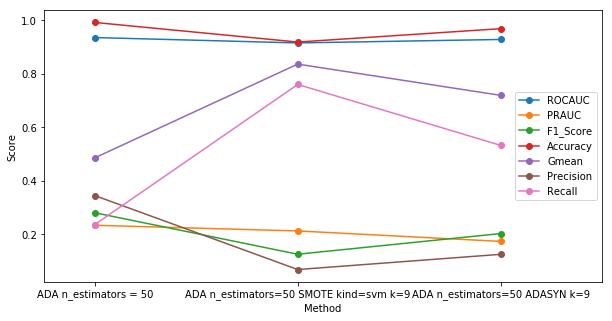

In [94]:
# Plot the results
%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt

figsize(10, 5)
ax = plt.subplot(111)

ind = np.arange(df_res.shape[0])
width = 0.2
l = ax.plot(ind, df_res, "-o")
leg = plt.legend(iter(l), df_res.columns.tolist(), loc='center right',fancybox=True)
#leg.get_frame().set_alpha(0.05)
plt.ylabel('Score')
plt.xlabel('Method')
ax.set_xlim([-0.25, ind[-1]+0.5])
ax.set_xticks(ind)
ax.set_xticklabels(df_res.index)
plt.show()
#plt.savefig("/Users/suruisun/Downloads/2017_fall/template-2/ada_metrics1.pdf",bbox_inches='tight')

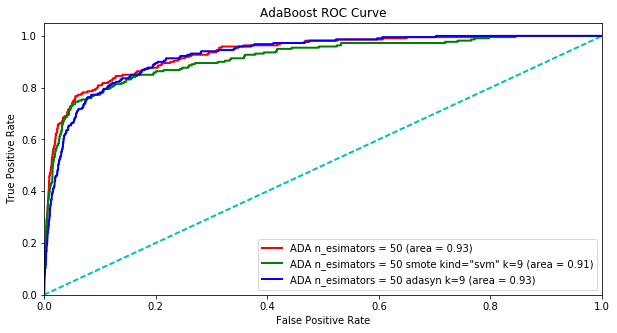

In [95]:
plt.figure(figsize=(10,5))
lw = 2
plt.plot(fpr_91, tpr_91, color='r', # #FD5C64
         lw=lw, label='ADA n_esimators = 50 (area = %0.2f)' % rocauc_temp9[0])
plt.plot([0, 1], [0, 1], color='c', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AdaBoost ROC Curve')

plt.plot(fpr_92, tpr_92, color='g', # #4DD3C9
         lw=lw, label='ADA n_esimators = 50 smote kind="svm" k=9 (area = %0.2f)' % rocauc_temp9[1])

plt.plot(fpr_93, tpr_93, color='b', # #FFA35D
         lw=lw, label='ADA n_esimators = 50 adasyn k=9 (area = %0.2f)' % rocauc_temp9[2])
plt.legend(loc="lower right")
#plt.savefig("/Users/suruisun/Downloads/2017_fall/template-2/ada_roc_curve1.pdf",bbox_inches='tight')
plt.show()

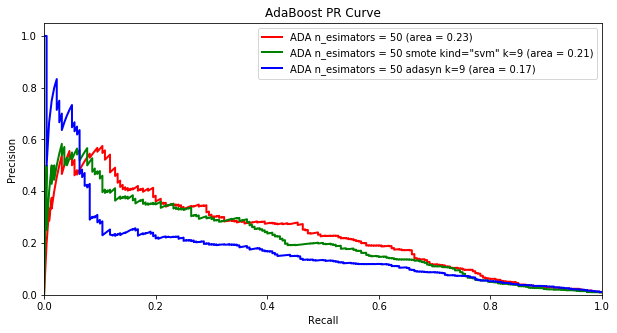

In [96]:
## draw the pr curve
plt.figure(figsize=(10,5))
lw = 2
plt.plot(recall_91, precision_91, color='r', # #FD5C64
         lw=lw, label='ADA n_esimators = 50 (area = %0.2f)' % prauc_temp9[0])
#plt.plot([0, 1], [0, 1], color='c', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('AdaBoost PR Curve')

plt.plot(recall_92, precision_92, color='g', # #4DD3C9
         lw=lw, label='ADA n_esimators = 50 smote kind="svm" k=9 (area = %0.2f)' % prauc_temp9[1])

plt.plot(recall_93, precision_93, color='b', # #FFA35D
         lw=lw, label='ADA n_esimators = 50 adasyn k=9 (area = %0.2f)' % prauc_temp9[2])
plt.legend(loc="upper right")
#plt.savefig("/Users/suruisun/Downloads/2017_fall/template-2/ada_pr_curve1.pdf",bbox_inches='tight')
plt.show()

# SVM

In [15]:
from sklearn.svm import SVC

In [98]:
### scaled data: SVM
start =time.time()
param_grid = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid']} # USE 'c' waste time running
clf = GridSearchCV(SVC(random_state=seed), param_grid,cv=3,scoring='accuracy')
clf.fit(X,Y)
print clf.best_params_
print time.time() - start

{'kernel': 'linear'}
122.217586994


In [100]:
aucpr_re = []
for kd in kind_list:
    for k in k_neighbors_list:
        print "=========="
        print kd
        print k
        pipe = os.SMOTE(kind=kd,random_state=seed,k_neighbors=k)
        pipeline = pl.make_pipeline(pipe,SVC(random_state=seed,kernel="linear")) # kernel="linear"
        
        start = time.time()
        
        pipeline.fit(X,Y)
        print "Elpased time: %s" %(time.time() - start)

        pred_9 = pipeline.predict(X_val_9)
        y_score_9 = pipeline.decision_function(X_val_9)
        result_f1_9 = f1_score(Y_val_9, pred_9)
        result_acc_9 = accuracy_score(Y_val_9, pred_9)
        result_conf_9 = confusion_matrix(Y_val_9, pred_9)
        result_prec_9 = precision_score(Y_val_9,pred_9)
        result_recall_9 = recall_score(Y_val_9,pred_9)
        result_gmean_9 = gmean(result_conf_9)
        result_prauc_9 = average_precision_score(Y_val_9, y_score_9)
        result_rocauc_9 = roc_auc_score(Y_val_9,y_score_9)
        #result_aucpr = average_precision_score(Y_val_unscaled, y_score)

#         print "f1: %s" %(result_f1_9)
#         print "acc: %s" %(result_acc_9)
#         print "conf: %s" %(result_conf_9)
#         print "precision: %s" %(result_prec_9)
#         print "recall: %s" %(result_recall_9)
#         print "gmean: %s" %(result_gmean_9)
        print "average precision: %s" %(result_prauc_9)
#         print "AUC ROC: %s" %(result_rocauc_9)
        aucpr_re.append(result_prauc_9)

regular
3
Elpased time: 724.780636072
average precision: 0.257926834266
regular
5
Elpased time: 713.968502998
average precision: 0.262817332484
regular
9
Elpased time: 722.399289846
average precision: 0.26698003647
borderline1
3
Elpased time: 262.035098076
average precision: 0.256439897541
borderline1
5
Elpased time: 254.006780148
average precision: 0.255404104236
borderline1
9
Elpased time: 266.584654093
average precision: 0.259372749152
borderline2
3
Elpased time: 226.298288822
average precision: 0.272911585041
borderline2
5
Elpased time: 227.224982977
average precision: 0.272157532355
borderline2
9
Elpased time: 231.441098928
average precision: 0.270779643035
svm
3
Elpased time: 184.070455074
average precision: 0.267648562112
svm
5
Elpased time: 174.884459019
average precision: 0.263492223367
svm
9
Elpased time: 182.414418936
average precision: 0.267052311533


In [101]:
np.where(aucpr_re == max(aucpr_re))[0][0]

6

Best parameter SMOTE: kind="borderline2" k=3

In [102]:
### Adasyn
aucpr_re = []
for k in k_neighbors_list:
    pipe = ADASYN(n_neighbors=k,random_state=seed)
    pipeline = pl.make_pipeline(pipe,SVC(random_state=seed,kernel="linear"))

    start = time.time()

    print "======="
    print "k=%s" %(k)
    pipeline.fit(X,Y)
    print "Elpased time: %s" %(time.time() - start)
    
    pred_9 = pipeline.predict(X_val_9)
    y_score_9 = pipeline.decision_function(X_val_9)
    result_f1_9 = f1_score(Y_val_9, pred_9)
    result_acc_9 = accuracy_score(Y_val_9, pred_9)
    result_conf_9 = confusion_matrix(Y_val_9, pred_9)
    result_prec_9 = precision_score(Y_val_9,pred_9)
    result_recall_9 = recall_score(Y_val_9,pred_9)
    result_gmean_9 = gmean(result_conf_9)
    result_prauc_9 = average_precision_score(Y_val_9, y_score_9)
    result_rocauc_9 = roc_auc_score(Y_val_9,y_score_9)
    #result_aucpr = average_precision_score(Y_val_unscaled, y_score)

#     print "f1: %s" %(result_f1_9)
#     print "acc: %s" %(result_acc_9)
#     print "conf: %s" %(result_conf_9)
#     print "precision: %s" %(result_prec_9)
#     print "recall: %s" %(result_recall_9)
#     print "gmean: %s" %(result_gmean_9)
    print "average precision: %s" %(result_prauc_9)
#     print "AUC ROC: %s" %(result_rocauc_9)
    aucpr_re.append(result_prauc_9)

k=3
Elpased time: 839.953191996
average precision: 0.262170413911
k=5
Elpased time: 868.098081827
average precision: 0.264284416085
k=9
Elpased time: 890.713732958
average precision: 0.261202768803


Best parameter ADASYN n_neighbors = 5

In [16]:
f1_temp9 = []
acc_temp9 = []
prec_temp9 = []
rec_temp9 = []
rocauc_temp9 = []
prauc_temp9 = []
gmean_temp9 = []
method_temp9 = []

In [17]:
## original method : 
model = SVC(kernel="linear",random_state=seed)
model.fit(X,Y)
pred_9 = model.predict(X_val_9)
# y_score_9 = best_clf.decision_function(X_val_9)
y_score_9 = model.decision_function(X_val_9)
result_f1_9 = f1_score(Y_val_9, pred_9)
result_acc_9 = accuracy_score(Y_val_9, pred_9)
result_conf_9 = confusion_matrix(Y_val_9, pred_9)
result_prec_9 = precision_score(Y_val_9,pred_9)
result_recall_9 = recall_score(Y_val_9,pred_9)
result_gmean_9 = gmean(result_conf_9)
result_prauc_9 = average_precision_score(Y_val_9, y_score_9)
result_rocauc_9 = roc_auc_score(Y_val_9,y_score_9)
fpr_91, tpr_91, thresholds_91 = roc_curve(Y_val_9, y_score_9)
precision_91, recall_91, thresholds_91 = precision_recall_curve(Y_val_9,y_score_9)



print "Confusion Matrix: %s" %(result_conf_9)
f1_temp9.append(result_f1_9)
acc_temp9.append(result_acc_9)
prec_temp9.append(result_prec_9)
rec_temp9.append(result_recall_9)
gmean_temp9.append(result_gmean_9)
rocauc_temp9.append(result_rocauc_9)
prauc_temp9.append(result_prauc_9)
method_temp9.append("SVM kernel=linear")

Confusion Matrix: [[27951     5]
 [  214     6]]


In [19]:
## best smote method:
pipe = os.SMOTE(kind="borderline2",random_state=seed,k_neighbors=3)
pipeline = pl.make_pipeline(pipe, SVC(kernel="linear",random_state=seed))

start = time.time()

pipeline.fit(X,Y)
print "Elpased time: %s" %(time.time() - start)

pred_9 = pipeline.predict(X_val_9)
y_score_9 = pipeline.decision_function(X_val_9)
result_f1_9 = f1_score(Y_val_9, pred_9)
result_acc_9 = accuracy_score(Y_val_9, pred_9)
result_conf_9 = confusion_matrix(Y_val_9, pred_9)
result_prec_9 = precision_score(Y_val_9,pred_9)
result_recall_9 = recall_score(Y_val_9,pred_9)
result_gmean_9 = gmean(result_conf_9)
result_prauc_9 = average_precision_score(Y_val_9, y_score_9)
result_rocauc_9 = roc_auc_score(Y_val_9,y_score_9)
#result_aucpr = average_precision_score(Y_val_unscaled, y_score)
fpr_92, tpr_92, thresholds_92 = roc_curve(Y_val_9, y_score_9)
precision_92, recall_92, thresholds_92 = precision_recall_curve(Y_val_9,y_score_9)
print "conf: %s" %(result_conf_9)

f1_temp9.append(result_f1_9)
acc_temp9.append(result_acc_9)
prec_temp9.append(result_prec_9)
rec_temp9.append(result_recall_9)
gmean_temp9.append(result_gmean_9)
rocauc_temp9.append(result_rocauc_9)
prauc_temp9.append(result_prauc_9)
method_temp9.append("SVM kernel=linear SMOTE kind=borderline2 k=3")

Elpased time: 287.959255934
conf: [[27191   765]
 [   64   156]]


In [20]:
## adasyn method:
pipe = ADASYN(n_neighbors=5,random_state=seed)
pipeline = pl.make_pipeline(pipe,SVC(random_state=seed,kernel="linear"))
start = time.time()
pipeline.fit(X,Y)
print "Elpased time: %s" %(time.time() - start)

pred_9 = pipeline.predict(X_val_9)
y_score_9 = pipeline.decision_function(X_val_9)
result_f1_9 = f1_score(Y_val_9, pred_9)
result_acc_9 = accuracy_score(Y_val_9, pred_9)
result_conf_9 = confusion_matrix(Y_val_9, pred_9)
result_prec_9 = precision_score(Y_val_9,pred_9)
result_recall_9 = recall_score(Y_val_9,pred_9)
result_gmean_9 = gmean(result_conf_9)
result_prauc_9 = average_precision_score(Y_val_9, y_score_9)
result_rocauc_9 = roc_auc_score(Y_val_9,y_score_9)
print "conf: %s" %(result_conf_9)
fpr_93, tpr_93, thresholds_93 = roc_curve(Y_val_9, y_score_9)
precision_93, recall_93, thresholds_93 = precision_recall_curve(Y_val_9,y_score_9)

f1_temp9.append(result_f1_9)
acc_temp9.append(result_acc_9)
prec_temp9.append(result_prec_9)
rec_temp9.append(result_recall_9)
gmean_temp9.append(result_gmean_9)
rocauc_temp9.append(result_rocauc_9)
prauc_temp9.append(result_prauc_9)
method_temp9.append("SVM Kernel=linear ADASYN k=5")

Elpased time: 1011.42302895
conf: [[26209  1747]
 [   47   173]]


In [21]:
print len(f1_temp9), len(acc_temp9), len(prec_temp9), len(rec_temp9), len(rocauc_temp9), len(prauc_temp9), len(gmean_temp9), len(method_temp9)
total_list = zip(method_temp9,rocauc_temp9, prauc_temp9, f1_temp9, acc_temp9, gmean_temp9, prec_temp9, rec_temp9)
df_res = pd.DataFrame(total_list,columns=['Method','ROCAUC','PRAUC','F1_Score','Accuracy','Gmean','Precision','Recall'])
df_res.index = df_res.Method.values
df_res.drop('Method',axis=1,inplace=True)
df_res

3 3 3 3 3 3 3 3


,ROCAUC,PRAUC,F1_Score,Accuracy,Gmean,Precision,Recall
SVM kernel=linear,0.854203,0.238569,0.051948,0.992227,0.165130,0.545455,0.027273
SVM kernel=linear SMOTE kind=borderline2 k=3,0.921333,0.272912,0.273444,0.970578,0.830474,0.169381,0.709091
SVM Kernel=linear ADASYN k=5,0.932960,0.264284,0.161682,0.936329,0.858617,0.090104,0.786364


In [22]:
df_res_svm = df_res

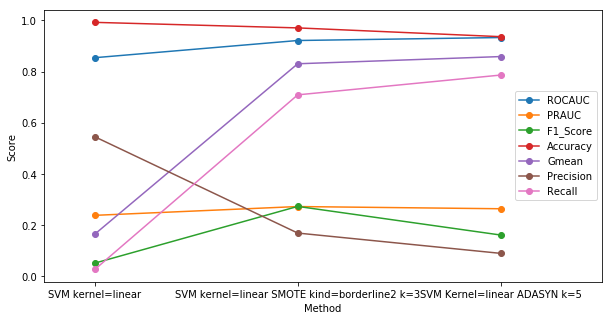

In [23]:
# Plot the results
%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt

figsize(10, 5)
ax = plt.subplot(111)

ind = np.arange(df_res.shape[0])
width = 0.2
l = ax.plot(ind, df_res, "-o")
leg = plt.legend(iter(l), df_res.columns.tolist(), loc='center right',fancybox=True)
#leg.get_frame().set_alpha(0.05)
plt.ylabel('Score')
plt.xlabel('Method')
ax.set_xlim([-0.25, ind[-1]+0.5])
ax.set_xticks(ind)
ax.set_xticklabels(df_res.index)
#plt.savefig("/Users/suruisun/Downloads/2017_fall/template-2/svm_metrics1.pdf",bbox_inches='tight')
plt.show()

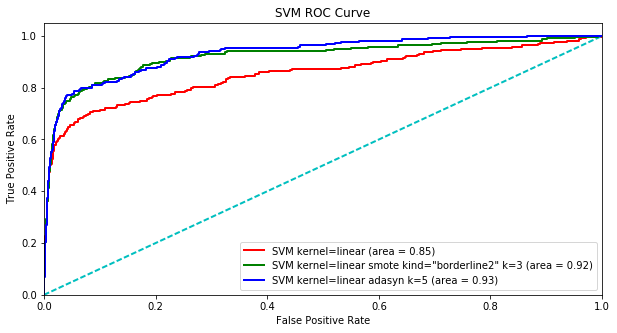

In [24]:
plt.figure(figsize=(10,5))
lw = 2
plt.plot(fpr_91, tpr_91, color='r', # #FD5C64
         lw=lw, label='SVM kernel=linear (area = %0.2f)' % rocauc_temp9[0])
plt.plot([0, 1], [0, 1], color='c', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM ROC Curve')

plt.plot(fpr_92, tpr_92, color='g', # #4DD3C9
         lw=lw, label='SVM kernel=linear smote kind="borderline2" k=3 (area = %0.2f)' % rocauc_temp9[1])

plt.plot(fpr_93, tpr_93, color='b', # #FFA35D
         lw=lw, label='SVM kernel=linear adasyn k=5 (area = %0.2f)' % rocauc_temp9[2])
plt.legend(loc="lower right")
#plt.savefig("/Users/suruisun/Downloads/2017_fall/template-2/svm_roc_curve1.pdf",bbox_inches='tight')
plt.show()

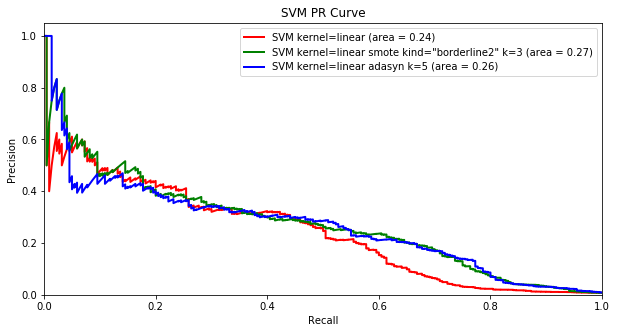

In [25]:
## draw the pr curve
plt.figure(figsize=(10,5))
lw = 2
plt.plot(recall_91, precision_91, color='r', # #FD5C64
         lw=lw, label='SVM kernel=linear (area = %0.2f)' % prauc_temp9[0])
#plt.plot([0, 1], [0, 1], color='c', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('SVM PR Curve')

plt.plot(recall_92, precision_92, color='g', # #4DD3C9
         lw=lw, label='SVM kernel=linear smote kind="borderline2" k=3 (area = %0.2f)' % prauc_temp9[1])

plt.plot(recall_93, precision_93, color='b', # #FFA35D
         lw=lw, label='SVM kernel=linear adasyn k=5 (area = %0.2f)' % prauc_temp9[2])
plt.legend(loc="upper right")
#plt.savefig("/Users/suruisun/Downloads/2017_fall/template-2/svm_pr_curve1.pdf",bbox_inches='tight')
plt.show()

# Naive Bayes

In [26]:
from sklearn.naive_bayes import GaussianNB

In [ ]:
## gaussian naive bayes 
best_clf = GaussianNB()
best_clf.fit(X,Y)
# testing for df_9
pred_9 = best_clf.predict(X_val_9)
y_score_9 = best_clf.predict_proba(X_val_9)[:,1]
result_f1_9 = f1_score(Y_val_9, pred_9)
result_acc_9 = accuracy_score(Y_val_9, pred_9)
result_conf_9 = confusion_matrix(Y_val_9, pred_9)
result_prec_9 = precision_score(Y_val_9,pred_9)
result_recall_9 = recall_score(Y_val_9,pred_9)
result_gmean_9 = gmean(result_conf_9)
result_prauc_9 = average_precision_score(Y_val_9, y_score_9)
result_rocauc_9 = roc_auc_score(Y_val_9,y_score_9)

print "f1: %s" %(result_f1_9)
print "acc: %s" %(result_acc_9)
print "conf: %s" %(result_conf_9)
print "precision: %s" %(result_prec_9)
print "recall: %s" %(result_recall_9)
print "gmean: %s" %(result_gmean_9)
print "average precision: %s" %(result_prauc_9)
print "AUC ROC: %s" %(result_rocauc_9)

f1_list9.append(result_f1_9)
acc_list9.append(result_acc_9)
prec_list9.append(result_prec_9)
rec_list9.append(result_recall_9)
gmean_list9.append(result_gmean_9)
rocauc_list9.append(result_rocauc_9)
prauc_list9.append(result_prauc_9)
method_list9.append("Gaussian NB")

# plot for roc curve and pr curve
fpr_9, tpr_9, thresholds_9 = roc_curve(Y_val_9, y_score_9)
precision_9, recall_9, thresholds_9 = precision_recall_curve(Y_val_9,y_score_9)

plt.figure()
lw = 2
plt.plot(fpr_9, tpr_9, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % result_rocauc_9)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Gaussian NB ROC Curve DATA 9')
plt.legend(loc="lower right")
plt.show()

plt.figure()
lw = 2
plt.plot(recall_9, precision_9, color='darkorange',
         lw=lw, label='PR curve (area = %0.2f)' % result_prauc_9)
#plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Gaussian NB PR Curve DATA 9')
plt.legend(loc="lower right")
plt.show()

In [27]:
aucpr_re = []
for kd in kind_list:
    for k in k_neighbors_list:
        print "=========="
        print kd
        print k
        pipe = os.SMOTE(kind=kd,random_state=seed,k_neighbors=k)
        pipeline = pl.make_pipeline(pipe,GaussianNB())
        
        start = time.time()
        
        pipeline.fit(X,Y)
        print "Elpased time: %s" %(time.time() - start)

        pred_9 = pipeline.predict(X_val_9)
        y_score_9 = pipeline.predict_proba(X_val_9)[:,1]
        result_f1_9 = f1_score(Y_val_9, pred_9)
        result_acc_9 = accuracy_score(Y_val_9, pred_9)
        result_conf_9 = confusion_matrix(Y_val_9, pred_9)
        result_prec_9 = precision_score(Y_val_9,pred_9)
        result_recall_9 = recall_score(Y_val_9,pred_9)
        result_gmean_9 = gmean(result_conf_9)
        result_prauc_9 = average_precision_score(Y_val_9, y_score_9)
        result_rocauc_9 = roc_auc_score(Y_val_9,y_score_9)
        #result_aucpr = average_precision_score(Y_val_unscaled, y_score)

#         print "f1: %s" %(result_f1_9)
#         print "acc: %s" %(result_acc_9)
#         print "conf: %s" %(result_conf_9)
#         print "precision: %s" %(result_prec_9)
#         print "recall: %s" %(result_recall_9)
#         print "gmean: %s" %(result_gmean_9)
        print "average precision: %s" %(result_prauc_9)
#         print "AUC ROC: %s" %(result_rocauc_9)
        aucpr_re.append(result_prauc_9)

regular
3
Elpased time: 0.412812948227
average precision: 0.352581437184
regular
5
Elpased time: 0.344508171082
average precision: 0.358376542064
regular
9
Elpased time: 0.339097976685
average precision: 0.357210790358
borderline1
3
Elpased time: 1.03381085396
average precision: 0.354338656227
borderline1
5
Elpased time: 1.11053705215
average precision: 0.360692186455
borderline1
9
Elpased time: 1.68266487122
average precision: 0.35852941662
borderline2
3
Elpased time: 1.56751084328
average precision: 0.355302305051
borderline2
5
Elpased time: 1.35101699829
average precision: 0.355558285703
borderline2
9
Elpased time: 1.27581000328
average precision: 0.358335481646
svm
3
Elpased time: 9.32663607597
average precision: 0.355638542663
svm
5
Elpased time: 8.15410900116
average precision: 0.356190556588
svm
9
Elpased time: 8.42342591286
average precision: 0.356855168407


In [28]:
np.where(aucpr_re == max(aucpr_re))[0][0]

4

Best parameter SMOTE: kind="borderline1" k=5

In [30]:
### Adasyn
aucpr_re = []
for k in k_neighbors_list:
    pipe = ADASYN(n_neighbors=k,random_state=seed)
    pipeline = pl.make_pipeline(pipe,GaussianNB())

    start = time.time()

    print "======="
    print "k=%s" %(k)
    pipeline.fit(X,Y)
    print "Elpased time: %s" %(time.time() - start)
    
    pred_9 = pipeline.predict(X_val_9)
    y_score_9 = pipeline.predict_proba(X_val_9)[:,1]
    result_f1_9 = f1_score(Y_val_9, pred_9)
    result_acc_9 = accuracy_score(Y_val_9, pred_9)
    result_conf_9 = confusion_matrix(Y_val_9, pred_9)
    result_prec_9 = precision_score(Y_val_9,pred_9)
    result_recall_9 = recall_score(Y_val_9,pred_9)
    result_gmean_9 = gmean(result_conf_9)
    result_prauc_9 = average_precision_score(Y_val_9, y_score_9)
    result_rocauc_9 = roc_auc_score(Y_val_9,y_score_9)
    #result_aucpr = average_precision_score(Y_val_unscaled, y_score)

#     print "f1: %s" %(result_f1_9)
#     print "acc: %s" %(result_acc_9)
#     print "conf: %s" %(result_conf_9)
#     print "precision: %s" %(result_prec_9)
#     print "recall: %s" %(result_recall_9)
#     print "gmean: %s" %(result_gmean_9)
    print "average precision: %s" %(result_prauc_9)
#     print "AUC ROC: %s" %(result_rocauc_9)
    aucpr_re.append(result_prauc_9)

k=3
Elpased time: 264.065449953
average precision: 0.342472705789
k=5
Elpased time: 233.706692934
average precision: 0.342434205448
k=9
Elpased time: 228.439660072
average precision: 0.339794632476


In [31]:
np.where(aucpr_re == max(aucpr_re))[0][0]

0

Best parameter ADASYN n_neighbors = 3

In [32]:
f1_temp9 = []
acc_temp9 = []
prec_temp9 = []
rec_temp9 = []
rocauc_temp9 = []
prauc_temp9 = []
gmean_temp9 = []
method_temp9 = []

In [33]:
## original method : 
model = GaussianNB()
model.fit(X,Y)
pred_9 = model.predict(X_val_9)
# y_score_9 = best_clf.decision_function(X_val_9)
y_score_9 = model.predict_proba(X_val_9)[:,1]
result_f1_9 = f1_score(Y_val_9, pred_9)
result_acc_9 = accuracy_score(Y_val_9, pred_9)
result_conf_9 = confusion_matrix(Y_val_9, pred_9)
result_prec_9 = precision_score(Y_val_9,pred_9)
result_recall_9 = recall_score(Y_val_9,pred_9)
result_gmean_9 = gmean(result_conf_9)
result_prauc_9 = average_precision_score(Y_val_9, y_score_9)
result_rocauc_9 = roc_auc_score(Y_val_9,y_score_9)
fpr_91, tpr_91, thresholds_91 = roc_curve(Y_val_9, y_score_9)
precision_91, recall_91, thresholds_91 = precision_recall_curve(Y_val_9,y_score_9)



print "Confusion Matrix: %s" %(result_conf_9)
f1_temp9.append(result_f1_9)
acc_temp9.append(result_acc_9)
prec_temp9.append(result_prec_9)
rec_temp9.append(result_recall_9)
gmean_temp9.append(result_gmean_9)
rocauc_temp9.append(result_rocauc_9)
prauc_temp9.append(result_prauc_9)
method_temp9.append("GaussianNB")

Confusion Matrix: [[26971   985]
 [   77   143]]


In [34]:
## best smote method:
pipe = os.SMOTE(kind="borderline1",random_state=seed,k_neighbors=5)
pipeline = pl.make_pipeline(pipe, GaussianNB())

start = time.time()

pipeline.fit(X,Y)
print "Elpased time: %s" %(time.time() - start)

pred_9 = pipeline.predict(X_val_9)
y_score_9 = pipeline.predict_proba(X_val_9)[:,1]
result_f1_9 = f1_score(Y_val_9, pred_9)
result_acc_9 = accuracy_score(Y_val_9, pred_9)
result_conf_9 = confusion_matrix(Y_val_9, pred_9)
result_prec_9 = precision_score(Y_val_9,pred_9)
result_recall_9 = recall_score(Y_val_9,pred_9)
result_gmean_9 = gmean(result_conf_9)
result_prauc_9 = average_precision_score(Y_val_9, y_score_9)
result_rocauc_9 = roc_auc_score(Y_val_9,y_score_9)
#result_aucpr = average_precision_score(Y_val_unscaled, y_score)
fpr_92, tpr_92, thresholds_92 = roc_curve(Y_val_9, y_score_9)
precision_92, recall_92, thresholds_92 = precision_recall_curve(Y_val_9,y_score_9)
print "conf: %s" %(result_conf_9)

f1_temp9.append(result_f1_9)
acc_temp9.append(result_acc_9)
prec_temp9.append(result_prec_9)
rec_temp9.append(result_recall_9)
gmean_temp9.append(result_gmean_9)
rocauc_temp9.append(result_rocauc_9)
prauc_temp9.append(result_prauc_9)
method_temp9.append("GaussianNB SMOTE kind=borderline1 k=5")

Elpased time: 1.67118501663
conf: [[26394  1562]
 [   57   163]]


In [35]:
## adasyn method:
pipe = ADASYN(n_neighbors=3,random_state=seed)
pipeline = pl.make_pipeline(pipe,GaussianNB())
start = time.time()
pipeline.fit(X,Y)
print "Elpased time: %s" %(time.time() - start)

pred_9 = pipeline.predict(X_val_9)
y_score_9 = pipeline.predict_proba(X_val_9)[:,1]
result_f1_9 = f1_score(Y_val_9, pred_9)
result_acc_9 = accuracy_score(Y_val_9, pred_9)
result_conf_9 = confusion_matrix(Y_val_9, pred_9)
result_prec_9 = precision_score(Y_val_9,pred_9)
result_recall_9 = recall_score(Y_val_9,pred_9)
result_gmean_9 = gmean(result_conf_9)
result_prauc_9 = average_precision_score(Y_val_9, y_score_9)
result_rocauc_9 = roc_auc_score(Y_val_9,y_score_9)
print "conf: %s" %(result_conf_9)
fpr_93, tpr_93, thresholds_93 = roc_curve(Y_val_9, y_score_9)
precision_93, recall_93, thresholds_93 = precision_recall_curve(Y_val_9,y_score_9)

f1_temp9.append(result_f1_9)
acc_temp9.append(result_acc_9)
prec_temp9.append(result_prec_9)
rec_temp9.append(result_recall_9)
gmean_temp9.append(result_gmean_9)
rocauc_temp9.append(result_rocauc_9)
prauc_temp9.append(result_prauc_9)
method_temp9.append("GaussianNB ADASYN k=3")

Elpased time: 252.864560843
conf: [[26826  1130]
 [   80   140]]


In [36]:
print len(f1_temp9), len(acc_temp9), len(prec_temp9), len(rec_temp9), len(rocauc_temp9), len(prauc_temp9), len(gmean_temp9), len(method_temp9)
total_list = zip(method_temp9,rocauc_temp9, prauc_temp9, f1_temp9, acc_temp9, gmean_temp9, prec_temp9, rec_temp9)
df_res = pd.DataFrame(total_list,columns=['Method','ROCAUC','PRAUC','F1_Score','Accuracy','Gmean','Precision','Recall'])
df_res.index = df_res.Method.values
df_res.drop('Method',axis=1,inplace=True)
df_res

3 3 3 3 3 3 3 3


,ROCAUC,PRAUC,F1_Score,Accuracy,Gmean,Precision,Recall
GaussianNB,0.925061,0.345211,0.212166,0.962308,0.791895,0.126773,0.650000
GaussianNB SMOTE kind=borderline1 k=5,0.867022,0.360692,0.167609,0.942540,0.836368,0.094493,0.740909
GaussianNB ADASYN k=3,0.925659,0.342473,0.187919,0.957056,0.781435,0.110236,0.636364


In [37]:
df_res_nb = df_res

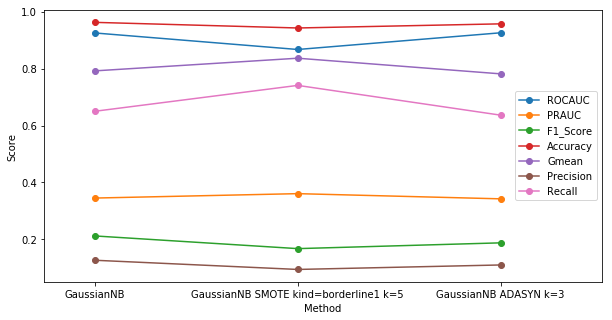

In [38]:
# Plot the results
%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt

figsize(10, 5)
ax = plt.subplot(111)

ind = np.arange(df_res.shape[0])
width = 0.2
l = ax.plot(ind, df_res, "-o")
leg = plt.legend(iter(l), df_res.columns.tolist(), loc='center right',fancybox=True)
#leg.get_frame().set_alpha(0.05)
plt.ylabel('Score')
plt.xlabel('Method')
ax.set_xlim([-0.25, ind[-1]+0.5])
#plt.legend(iter(l), df_res.columns.tolist(), loc='upper left', bbox_to_anchor=(1, 0.5)) # center left
#ax.set_xlim([-0.25, ind[-1]+.25])
ax.set_xticks(ind)
ax.set_xticklabels(df_res.index)
#plt.savefig("/Users/suruisun/Downloads/2017_fall/template-2/naive_bayes_metrics1.pdf",bbox_inches='tight')
plt.show()

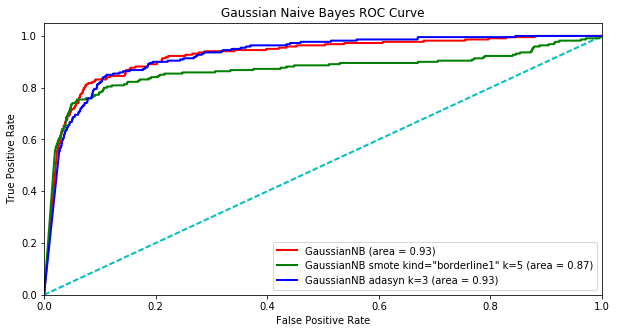

In [39]:
plt.figure(figsize=(10,5))
lw = 2
plt.plot(fpr_91, tpr_91, color='r', # #FD5C64
         lw=lw, label='GaussianNB (area = %0.2f)' % rocauc_temp9[0])
plt.plot([0, 1], [0, 1], color='c', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Gaussian Naive Bayes ROC Curve')

plt.plot(fpr_92, tpr_92, color='g', # #4DD3C9
         lw=lw, label='GaussianNB smote kind="borderline1" k=5 (area = %0.2f)' % rocauc_temp9[1])

plt.plot(fpr_93, tpr_93, color='b', # #FFA35D
         lw=lw, label='GaussianNB adasyn k=3 (area = %0.2f)' % rocauc_temp9[2])
plt.legend(loc="lower right")
#plt.savefig("/Users/suruisun/Downloads/2017_fall/template-2/GaussianNB_roc_curve1.pdf",bbox_inches='tight')
plt.show()

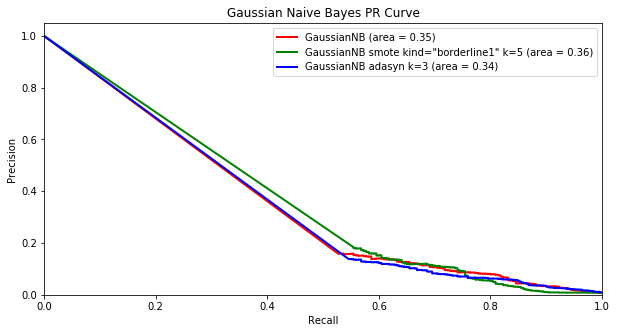

In [40]:
## draw the pr curve
plt.figure(figsize=(10,5))
lw = 2
plt.plot(recall_91, precision_91, color='r', # #FD5C64
         lw=lw, label='GaussianNB (area = %0.2f)' % prauc_temp9[0])
#plt.plot([0, 1], [0, 1], color='c', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Gaussian Naive Bayes PR Curve')

plt.plot(recall_92, precision_92, color='g', # #4DD3C9
         lw=lw, label='GaussianNB smote kind="borderline1" k=5 (area = %0.2f)' % prauc_temp9[1])

plt.plot(recall_93, precision_93, color='b', # #FFA35D
         lw=lw, label='GaussianNB adasyn k=3 (area = %0.2f)' % prauc_temp9[2])
plt.legend(loc="upper right")
#plt.savefig("/Users/suruisun/Downloads/2017_fall/template-2/GaussianNB_pr_curve1.pdf",bbox_inches='tight')
plt.show()

# Linear Discriminant Analysis

In [41]:
from sklearn.lda import LDA

//anaconda/envs/py27/lib/python2.7/site-packages/sklearn/lda.py:4: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and will be removed in 0.19", DeprecationWarning)


In [42]:
aucpr_re = []
for kd in kind_list:
    for k in k_neighbors_list:
        print "=========="
        print kd
        print k
        pipe = os.SMOTE(kind=kd,random_state=seed,k_neighbors=k)
        pipeline = pl.make_pipeline(pipe,LDA())
        
        start = time.time()
        
        pipeline.fit(X,Y)
        print "Elpased time: %s" %(time.time() - start)

        pred_9 = pipeline.predict(X_val_9)
        y_score_9 = pipeline.predict_proba(X_val_9)[:,1]
        result_f1_9 = f1_score(Y_val_9, pred_9)
        result_acc_9 = accuracy_score(Y_val_9, pred_9)
        result_conf_9 = confusion_matrix(Y_val_9, pred_9)
        result_prec_9 = precision_score(Y_val_9,pred_9)
        result_recall_9 = recall_score(Y_val_9,pred_9)
        result_gmean_9 = gmean(result_conf_9)
        result_prauc_9 = average_precision_score(Y_val_9, y_score_9)
        result_rocauc_9 = roc_auc_score(Y_val_9,y_score_9)
        #result_aucpr = average_precision_score(Y_val_unscaled, y_score)

#         print "f1: %s" %(result_f1_9)
#         print "acc: %s" %(result_acc_9)
#         print "conf: %s" %(result_conf_9)
#         print "precision: %s" %(result_prec_9)
#         print "recall: %s" %(result_recall_9)
#         print "gmean: %s" %(result_gmean_9)
        print "average precision: %s" %(result_prauc_9)
#         print "AUC ROC: %s" %(result_rocauc_9)
        aucpr_re.append(result_prauc_9)

regular
3
Elpased time: 1.04999089241
average precision: 0.164240445358
regular
5
Elpased time: 0.778800964355
average precision: 0.16713984282
regular
9
Elpased time: 0.773587942123
average precision: 0.171252104474
borderline1
3
Elpased time: 1.63107204437
average precision: 0.178689127836
borderline1
5
Elpased time: 1.72064089775
average precision: 0.177395374854
borderline1
9
Elpased time: 1.63199806213
average precision: 0.181049533772
borderline2
3
Elpased time: 1.63329792023
average precision: 0.182296654271
borderline2
5
Elpased time: 1.53440117836
average precision: 0.182271881126
borderline2
9
Elpased time: 1.68073606491
average precision: 0.18374231055
svm
3
Elpased time: 8.86418294907
average precision: 0.180578230691
svm
5
Elpased time: 8.44367599487
average precision: 0.183821796726
svm
9
Elpased time: 8.72313809395
average precision: 0.183010699951


In [43]:
np.where(aucpr_re == max(aucpr_re))[0][0]

10

Best parameter SMOTE: kind="svm" k=5

In [45]:
### Adasyn
aucpr_re = []
for k in k_neighbors_list:
    pipe = ADASYN(n_neighbors=k,random_state=seed)
    pipeline = pl.make_pipeline(pipe,LDA())

    start = time.time()

    print "======="
    print "k=%s" %(k)
    pipeline.fit(X,Y)
    print "Elpased time: %s" %(time.time() - start)
    
    pred_9 = pipeline.predict(X_val_9)
    y_score_9 = pipeline.predict_proba(X_val_9)[:,1]
    result_f1_9 = f1_score(Y_val_9, pred_9)
    result_acc_9 = accuracy_score(Y_val_9, pred_9)
    result_conf_9 = confusion_matrix(Y_val_9, pred_9)
    result_prec_9 = precision_score(Y_val_9,pred_9)
    result_recall_9 = recall_score(Y_val_9,pred_9)
    result_gmean_9 = gmean(result_conf_9)
    result_prauc_9 = average_precision_score(Y_val_9, y_score_9)
    result_rocauc_9 = roc_auc_score(Y_val_9,y_score_9)
    #result_aucpr = average_precision_score(Y_val_unscaled, y_score)

#     print "f1: %s" %(result_f1_9)
#     print "acc: %s" %(result_acc_9)
#     print "conf: %s" %(result_conf_9)
#     print "precision: %s" %(result_prec_9)
#     print "recall: %s" %(result_recall_9)
#     print "gmean: %s" %(result_gmean_9)
    print "average precision: %s" %(result_prauc_9)
#     print "AUC ROC: %s" %(result_rocauc_9)

    aucpr_re.append(result_prauc_9)

k=3
Elpased time: 257.68757391
average precision: 0.162881126185
k=5
Elpased time: 261.883745909
average precision: 0.167646615754
k=9
Elpased time: 255.135519028
average precision: 0.170569676718


In [46]:
np.where(aucpr_re == max(aucpr_re))[0][0]

2

Best parameter ADASYN n_neighbors = 9

In [47]:
f1_temp9 = []
acc_temp9 = []
prec_temp9 = []
rec_temp9 = []
rocauc_temp9 = []
prauc_temp9 = []
gmean_temp9 = []
method_temp9 = []

In [48]:
## original method : 
model = LDA()
model.fit(X,Y)
pred_9 = model.predict(X_val_9)
# y_score_9 = best_clf.decision_function(X_val_9)
y_score_9 = model.predict_proba(X_val_9)[:,1]
result_f1_9 = f1_score(Y_val_9, pred_9)
result_acc_9 = accuracy_score(Y_val_9, pred_9)
result_conf_9 = confusion_matrix(Y_val_9, pred_9)
result_prec_9 = precision_score(Y_val_9,pred_9)
result_recall_9 = recall_score(Y_val_9,pred_9)
result_gmean_9 = gmean(result_conf_9)
result_prauc_9 = average_precision_score(Y_val_9, y_score_9)
result_rocauc_9 = roc_auc_score(Y_val_9,y_score_9)
fpr_91, tpr_91, thresholds_91 = roc_curve(Y_val_9, y_score_9)
precision_91, recall_91, thresholds_91 = precision_recall_curve(Y_val_9,y_score_9)


print "Confusion Matrix: %s" %(result_conf_9)
f1_temp9.append(result_f1_9)
acc_temp9.append(result_acc_9)
prec_temp9.append(result_prec_9)
rec_temp9.append(result_recall_9)
gmean_temp9.append(result_gmean_9)
rocauc_temp9.append(result_rocauc_9)
prauc_temp9.append(result_prauc_9)
method_temp9.append("LDA")

Confusion Matrix: [[27723   233]
 [  117   103]]


In [49]:
## best smote method:
pipe = os.SMOTE(kind="svm",random_state=seed,k_neighbors=5)
pipeline = pl.make_pipeline(pipe, LDA())

start = time.time()

pipeline.fit(X,Y)
print "Elpased time: %s" %(time.time() - start)

pred_9 = pipeline.predict(X_val_9)
y_score_9 = pipeline.predict_proba(X_val_9)[:,1]
result_f1_9 = f1_score(Y_val_9, pred_9)
result_acc_9 = accuracy_score(Y_val_9, pred_9)
result_conf_9 = confusion_matrix(Y_val_9, pred_9)
result_prec_9 = precision_score(Y_val_9,pred_9)
result_recall_9 = recall_score(Y_val_9,pred_9)
result_gmean_9 = gmean(result_conf_9)
result_prauc_9 = average_precision_score(Y_val_9, y_score_9)
result_rocauc_9 = roc_auc_score(Y_val_9,y_score_9)
#result_aucpr = average_precision_score(Y_val_unscaled, y_score)
fpr_92, tpr_92, thresholds_92 = roc_curve(Y_val_9, y_score_9)
precision_92, recall_92, thresholds_92 = precision_recall_curve(Y_val_9,y_score_9)
print "conf: %s" %(result_conf_9)

f1_temp9.append(result_f1_9)
acc_temp9.append(result_acc_9)
prec_temp9.append(result_prec_9)
rec_temp9.append(result_recall_9)
gmean_temp9.append(result_gmean_9)
rocauc_temp9.append(result_rocauc_9)
prauc_temp9.append(result_prauc_9)
method_temp9.append("LDA SMOTE kind=svm k=5")

Elpased time: 10.1722149849
conf: [[27092   864]
 [   84   136]]


In [50]:
## adasyn method:
pipe = ADASYN(n_neighbors=9,random_state=seed)
pipeline = pl.make_pipeline(pipe,LDA())
start = time.time()
pipeline.fit(X,Y)
print "Elpased time: %s" %(time.time() - start)

pred_9 = pipeline.predict(X_val_9)
y_score_9 = pipeline.predict_proba(X_val_9)[:,1]
result_f1_9 = f1_score(Y_val_9, pred_9)
result_acc_9 = accuracy_score(Y_val_9, pred_9)
result_conf_9 = confusion_matrix(Y_val_9, pred_9)
result_prec_9 = precision_score(Y_val_9,pred_9)
result_recall_9 = recall_score(Y_val_9,pred_9)
result_gmean_9 = gmean(result_conf_9)
result_prauc_9 = average_precision_score(Y_val_9, y_score_9)
result_rocauc_9 = roc_auc_score(Y_val_9,y_score_9)
print "conf: %s" %(result_conf_9)
fpr_93, tpr_93, thresholds_93 = roc_curve(Y_val_9, y_score_9)
precision_93, recall_93, thresholds_93 = precision_recall_curve(Y_val_9,y_score_9)

f1_temp9.append(result_f1_9)
acc_temp9.append(result_acc_9)
prec_temp9.append(result_prec_9)
rec_temp9.append(result_recall_9)
gmean_temp9.append(result_gmean_9)
rocauc_temp9.append(result_rocauc_9)
prauc_temp9.append(result_prauc_9)
method_temp9.append("LDA ADASYN k=9")

Elpased time: 242.146816969
conf: [[25879  2077]
 [   53   167]]


In [51]:
print len(f1_temp9), len(acc_temp9), len(prec_temp9), len(rec_temp9), len(rocauc_temp9), len(prauc_temp9), len(gmean_temp9), len(method_temp9)
total_list = zip(method_temp9,rocauc_temp9, prauc_temp9, f1_temp9, acc_temp9, gmean_temp9, prec_temp9, rec_temp9)
df_res = pd.DataFrame(total_list,columns=['Method','ROCAUC','PRAUC','F1_Score','Accuracy','Gmean','Precision','Recall'])
df_res.index = df_res.Method.values
df_res.drop('Method',axis=1,inplace=True)
df_res

3 3 3 3 3 3 3 3


,ROCAUC,PRAUC,F1_Score,Accuracy,Gmean,Precision,Recall
LDA,0.942773,0.304630,0.370504,0.987578,0.681381,0.306548,0.468182
LDA SMOTE kind=svm k=5,0.927922,0.183822,0.222951,0.966354,0.774000,0.136000,0.618182
LDA ADASYN k=9,0.924913,0.170570,0.135552,0.924404,0.838268,0.074421,0.759091


In [52]:
df_res_lda = df_res

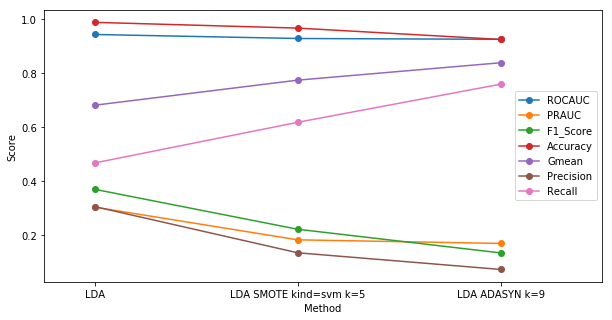

In [53]:
# Plot the results
%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt

figsize(10, 5)
ax = plt.subplot(111)

ind = np.arange(df_res.shape[0])
width = 0.2
l = ax.plot(ind, df_res, "-o")
leg = plt.legend(iter(l), df_res.columns.tolist(), loc='center right',fancybox=True)
#leg.get_frame().set_alpha(0.05)
plt.ylabel('Score')
plt.xlabel('Method')
ax.set_xlim([-0.25, ind[-1]+0.5])
ax.set_xticks(ind)
ax.set_xticklabels(df_res.index)
#plt.savefig("/Users/suruisun/Downloads/2017_fall/template-2/lda_metrics1.pdf",bbox_inches='tight')
plt.show()

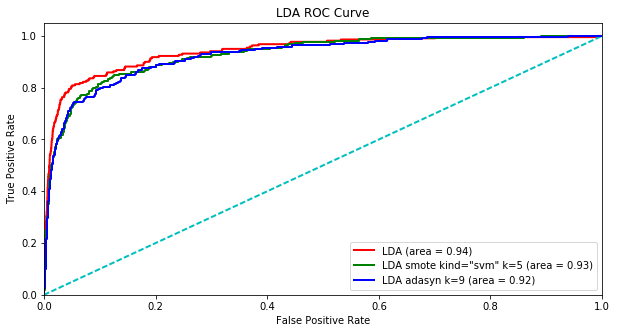

In [54]:
plt.figure(figsize=(10,5))
lw = 2
plt.plot(fpr_91, tpr_91, color='r', # #FD5C64
         lw=lw, label='LDA (area = %0.2f)' % rocauc_temp9[0])
plt.plot([0, 1], [0, 1], color='c', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LDA ROC Curve')

plt.plot(fpr_92, tpr_92, color='g', # #4DD3C9
         lw=lw, label='LDA smote kind="svm" k=5 (area = %0.2f)' % rocauc_temp9[1])

plt.plot(fpr_93, tpr_93, color='b', # #FFA35D
         lw=lw, label='LDA adasyn k=9 (area = %0.2f)' % rocauc_temp9[2])
plt.legend(loc="lower right")
#plt.savefig("/Users/suruisun/Downloads/2017_fall/template-2/lda_roc_curve1.pdf",bbox_inches='tight')
plt.show()

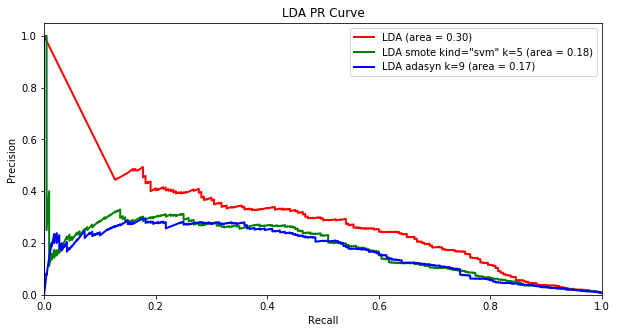

In [55]:
## draw the pr curve
plt.figure(figsize=(10,5))
lw = 2
plt.plot(recall_91, precision_91, color='r', # #FD5C64
         lw=lw, label='LDA (area = %0.2f)' % prauc_temp9[0])
#plt.plot([0, 1], [0, 1], color='c', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('LDA PR Curve')

plt.plot(recall_92, precision_92, color='g', # #4DD3C9
         lw=lw, label='LDA smote kind="svm" k=5 (area = %0.2f)' % prauc_temp9[1])

plt.plot(recall_93, precision_93, color='b', # #FFA35D
         lw=lw, label='LDA adasyn k=9 (area = %0.2f)' % prauc_temp9[2])
plt.legend(loc="upper right")
#plt.savefig("/Users/suruisun/Downloads/2017_fall/template-2/lda_pr_curve1.pdf",bbox_inches='tight')
plt.show()

# PCA

In [56]:
from sklearn.decomposition import PCA

In [58]:
pca = PCA(n_components=2)
X_pca_res = pca.fit(X).transform(X)

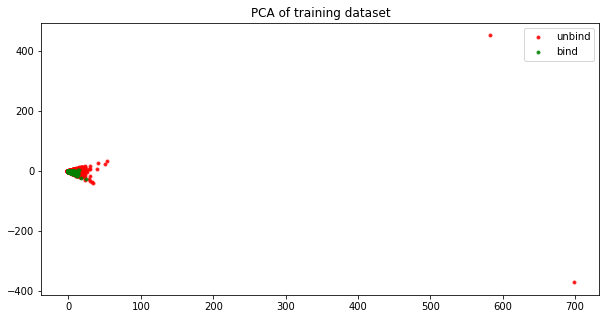

In [59]:
plt.figure(figsize=(10,5))
plt.scatter(X_pca_res[Y == 0.0, 0], X_pca_res[Y == 0.0, 1], color='r', alpha=.8, lw=2, label='unbind',s=4)
plt.scatter(X_pca_res[Y == 1.0, 0], X_pca_res[Y == 1.0, 1], color='g', alpha=.8, lw=2,label='bind',s=4)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of training dataset')

Plot after dropping the outliers:

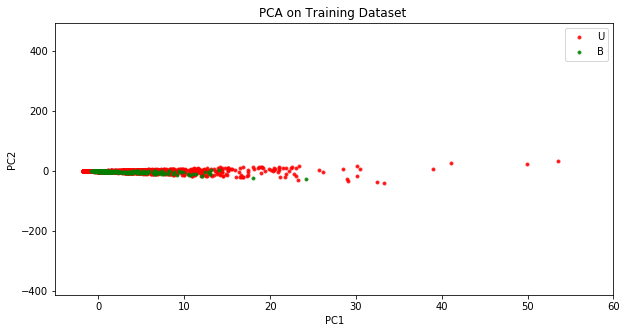

In [60]:
plt.figure(figsize=(10,5))
plt.scatter(X_pca_res[Y == 0.0, 0], X_pca_res[Y == 0.0, 1], color='r', alpha=.8, lw=2, label='U',s=4)
plt.scatter(X_pca_res[Y == 1.0, 0], X_pca_res[Y == 1.0, 1], color='g', alpha=.8, lw=2,label='B',s=4)
plt.xlim([-5,60])
#plt.ylim([-50,40])
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(loc='best')
plt.title('PCA on Training Dataset ')

In [61]:
## loadings of the PCA
loadings = pca.components_

# PCA SMOTE kind="regular"

In [62]:
## data after smote for LR
sm = os.SMOTE(random_state=seed,k_neighbors=5,kind="regular")
X_res_smote, y_res_smote = sm.fit_sample(X, Y)
print X_res_smote.shape, y_res_smote.shape

(53606, 61) (53606,)


In [63]:
X_smote_pca = np.dot(X_res_smote,loadings.T)
print X_smote_pca.shape

(53606, 2)


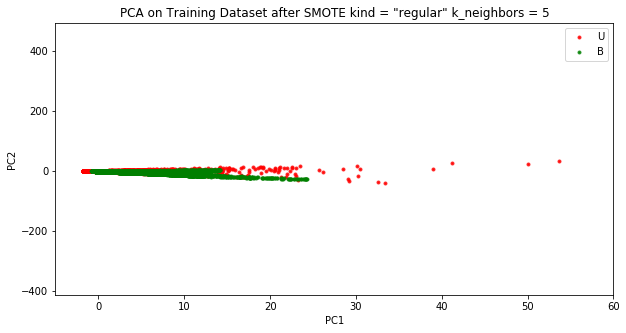

In [64]:
plt.figure(figsize=(10,5))
plt.scatter(X_smote_pca[y_res_smote == 0.0, 0], X_smote_pca[y_res_smote == 0.0, 1], color='r', alpha=.8, lw=2, label='U',s=4)
plt.scatter(X_smote_pca[y_res_smote == 1.0, 0], X_smote_pca[y_res_smote == 1.0, 1], color='g', alpha=.8, lw=2,label='B',s=4)
plt.xlim([-5,60]) ## this is after removing the outliers
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(loc='best')
plt.title('PCA on Training Dataset after SMOTE kind = "regular" k_neighbors = 5')
#plt.savefig("/Users/suruisun/Downloads/2017_fall/template-2/pca_smote_regular.pdf")
plt.show()

# PCA smote kind="borderline1"

In [66]:
## data after smote for LR
sm = os.SMOTE(random_state=seed,k_neighbors=5,kind="borderline1")
X_res_smote, y_res_smote = sm.fit_sample(X, Y)
print X_res_smote.shape, y_res_smote.shape

(53606, 61) (53606,)


In [67]:
X_smote_pca = np.dot(X_res_smote,loadings.T)
print X_smote_pca.shape

(53606, 2)


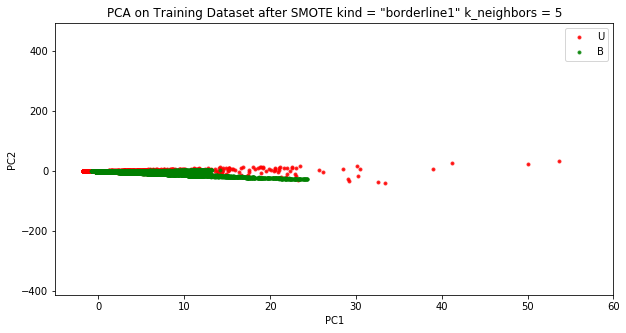

In [68]:
plt.figure(figsize=(10,5))
plt.scatter(X_smote_pca[y_res_smote == 0.0, 0], X_smote_pca[y_res_smote == 0.0, 1], color='r', alpha=.8, lw=2, label='U',s=4)
plt.scatter(X_smote_pca[y_res_smote == 1.0, 0], X_smote_pca[y_res_smote == 1.0, 1], color='g', alpha=.8, lw=2,label='B',s=4)
plt.xlim([-5,60])
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(loc='best')
plt.title('PCA on Training Dataset after SMOTE kind = "borderline1" k_neighbors = 5')
plt.show()

# PCA smote kind="borderline2"

In [70]:
## data after smote for LR
sm = os.SMOTE(random_state=seed,k_neighbors=5,kind="borderline2")
X_res_smote, y_res_smote = sm.fit_sample(X, Y)
print X_res_smote.shape, y_res_smote.shape

(53606, 61) (53606,)


In [71]:
X_smote_pca = np.dot(X_res_smote,loadings.T)
print X_smote_pca.shape

(53606, 2)


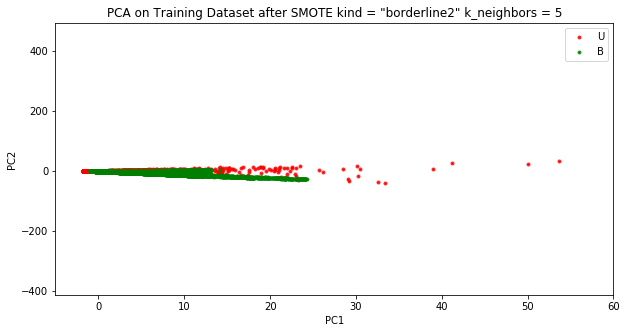

In [72]:
plt.figure(figsize=(10,5))
plt.scatter(X_smote_pca[y_res_smote == 0.0, 0], X_smote_pca[y_res_smote == 0.0, 1], color='r', alpha=.8, lw=2, label='U',s=4)
plt.scatter(X_smote_pca[y_res_smote == 1.0, 0], X_smote_pca[y_res_smote == 1.0, 1], color='g', alpha=.8, lw=2,label='B',s=4)
plt.xlim([-5,60])
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(loc='best')
plt.title('PCA on Training Dataset after SMOTE kind = "borderline2" k_neighbors = 5')
plt.show()

# PCA smote kind="svm"

In [74]:
## data after smote for LR
sm = os.SMOTE(random_state=seed,k_neighbors=5,kind="svm")
X_res, y_res = sm.fit_sample(X, Y)
print X_res.shape, y_res.shape

(53606, 61) (53606,)


In [75]:
X_smote_pca = np.dot(X_res_smote,loadings.T)
print X_smote_pca.shape

(53606, 2)


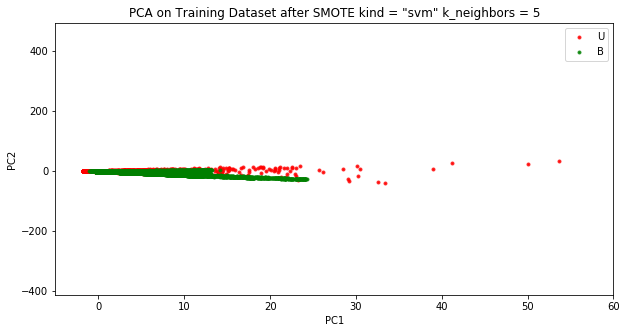

In [76]:
plt.figure(figsize=(10,5))
plt.scatter(X_smote_pca[y_res_smote == 0.0, 0], X_smote_pca[y_res_smote == 0.0, 1], color='r', alpha=.8, lw=2, label='U',s=4)
plt.scatter(X_smote_pca[y_res_smote == 1.0, 0], X_smote_pca[y_res_smote == 1.0, 1], color='g', alpha=.8, lw=2,label='B',s=4)
plt.xlim([-5,60])
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(loc='best')
plt.title('PCA on Training Dataset after SMOTE kind = "svm" k_neighbors = 5')
plt.show()

# PCA adasyn

In [69]:
### adasyn k=9
ada = ADASYN(random_state=seed)
X_res_adasyn, y_res_adasyn = ada.fit_sample(X, Y)
print X_res_adasyn.shape, y_res_adasyn.shape

(53619, 61) (53619,)


In [77]:
X_adasyn_pca = np.dot(X_res_adasyn,loadings.T)
print X_adasyn_pca.shape

(53619, 2)


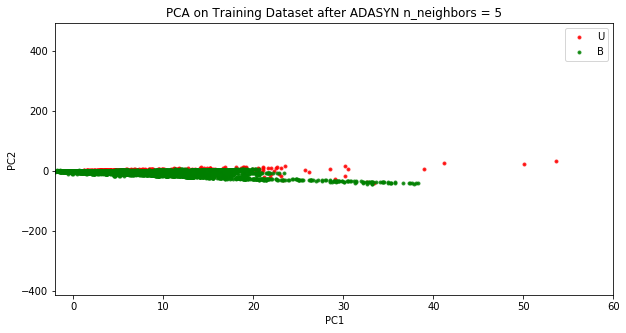

In [78]:
## adasyn
plt.figure(figsize=(10,5))
plt.scatter(X_adasyn_pca[y_res_adasyn == 0.0, 0], X_adasyn_pca[y_res_adasyn == 0.0, 1], color='r', alpha=.8, lw=2, label='U',s=4)
plt.scatter(X_adasyn_pca[y_res_adasyn == 1.0, 0], X_adasyn_pca[y_res_adasyn == 1.0, 1], color='g', alpha=.8, lw=2,label='B',s=4)
plt.xlim([-2,60])
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(loc='best')
plt.title('PCA on Training Dataset after ADASYN n_neighbors = 5')
plt.show()

Above are the main coding scripts for the thesis.


At last, thank you for reading this script.